## A and P site matrix at Amino aicd level, tRNA level and Codon level

# Data analysis workflow for the study "A and P site matrix at Amino aicd level, tRNA level and Codon level - Ribosome predictably and causally modulate translation-elongation rates"

### For analysis used 7 ribo-seq dataset and & 75% coverage genes are selected

##### List of published datasets used in this study
1. Jan, C. H., Williams, C. C., & Weissman, J. S. (2014). Principles of ER cotranslational translocation revealed by proximity-specific ribosome profiling. Science, 346(6210).

2. Williams, C. C., Jan, C. H., & Weissman, J. S. (2014). Targeting and plasticity of mitochondrial proteins revealed by proximity-specific ribosome profiling. Science, 346(6210), 748-751.

3. Young, D. J., Guydosh, N. R., Zhang, F., Hinnebusch, A. G., & Green, R. (2015). Rli1/ABCE1 recycles terminating ribosomes and controls translation reinitiation in 3′ UTRs in vivo. Cell, 162(4), 872-884.

4. Weinberg, D. E., Shah, P., Eichhorn, S. W., Hussmann, J. A., Plotkin, J. B., & Bartel, D. P. (2016). Improved ribosome-footprint and mRNA measurements provide insights into dynamics and regulation of yeast translation. Cell reports, 14(7), 1787-1799.

5. Nissley, D. A., Sharma, A. K., Ahmed, N., Friedrich, U. A., Kramer, G., Bukau, B., & O’Brien, E. P. (2016). Accurate prediction of cellular co-translational folding indicates proteins can switch from post-to co-translational folding. Nature communications, 7(1), 1-13.

6. Ahmed, N., Sormanni, P., Ciryam, P., Vendruscolo, M., Dobson, C. M., & O’Brien, E. P. (2019). Identifying A-and P-site locations on ribosome-protected mRNA fragments using Integer Programming. Scientific reports, 9(1), 1-14.

The wild-type ribosome profiling data samples from the above studies (See Accession numbers in Table S1) (Removed mutated genes from Ahmed et al. riboseq datasete) were processed according to their Methods section and the reads were mapped to the A-site positions using the Integer Programming algorithm (see https://www.nature.com/articles/s41598-019-42348-x for details). The alignment files for the above datasets was run through custom code (see https://github.com/nabeel-bioinfo/Asite_IP_method) and two files are generated for each dataset that will be used as input for the data analysis in this notebook. The two files for each dataset are

1) A-site_profiles.tab: Contains comma-delimited profile of raw reads assigned to A-site positions for each nucleotide position of the transcript.

2) Multiple_mapped_gene_read_counts_20_35.tab: A custom file specifying reads for each fragment length from 20 to 35 that are multiple mapped. The read count from this file will be used to filter out genes that have greater than 0.1% multiple mapped reads across their transcript.

In [9]:
# Parameter define
data_sets = ['Williams', 'Jan', 'Nissley1', 'Nissley2', 'Weinberg', 'Young','Pool']
coverage_value = 75  #(mean 75 mean 75% coverage gene with minimumm one read per codon )
read_per_codon = 1

#Intronic gene list
Intronic_gene_list = 'reference_files/intronic_genes.p'

#Overlap gene list
Overlap_gene_list = 'reference_files/overlap_genes.p'

#dict_cdn_types = pickle.load(open('reference_files/codon_type_dict.p', 'rb'))

threshold_value =4

print('Done')

Done


In [23]:
from __future__ import division
from __future__ import division
import matplotlib
import numpy as np
import math
import os
import pickle
from optparse import OptionParser
import matplotlib.backends.backend_pdf as pdf
from scipy import stats
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.table import Table
import sys
import statsmodels.sandbox.stats.multicomp as mc
import operator as op
from matplotlib.ticker import FormatStrFormatter
from time import localtime, strftime
import itertools
from matplotlib import rcParams
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.pyplot as plt
import shutil


CODON_TYPES = ['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA', 'AUG', 'GUU', 'GUC', 'GUA',
               'GUG', 'UCU', 'UCC', 'UCA', 'UCG', 'CCU', 'CCC', 'CCA', 'CCG', 'ACU', 'ACC', 'ACA', 'ACG', 'GCU', 'GCC',
               'GCA', 'GCG', 'UAU', 'UAC', 'CAU', 'CAC', 'CAA', 'CAG', 'AAU', 'AAC', 'AAA', 'AAG', 'GAU', 'GAC', 'GAA',
               'GAG', 'UGU', 'UGC', 'UGG', 'CGU', 'CGC', 'CGA', 'CGG', 'AGU', 'AGC', 'AGA', 'AGG', 'GGU', 'GGC', 'GGA',
               'GGG', 'UAA', 'UAG', 'UGA']

genetic_code = {'UUU': 'F', 'UCU': 'S', 'UAU': 'Y', 'UGU': 'C', 'UUC': 'F', 'UCC': 'S', 'UAC': 'Y', 'UGC': 'C',
                'UUA': 'L', 'UCA': 'S', 'UAA': '*', 'UGA': '*', 'UUG': 'L', 'UCG': 'S', 'UAG': '*', 'UGG': 'W',
                'CUU': 'L', 'CCU': 'P', 'CAU': 'H', 'CGU': 'R', 'CUC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
                'CUA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R', 'CUG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',
                'AUU': 'I', 'ACU': 'T', 'AAU': 'N', 'AGU': 'S', 'AUC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
                'AUA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R', 'AUG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',
                'GUU': 'V', 'GCU': 'A', 'GAU': 'D', 'GGU': 'G', 'GUC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
                'GUA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G', 'GUG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G'}

# In the following dict, synonymous codons for each amino acid are grouped in list such that they are decoded by similar tRNA.
# For example, in amino acid 'A', GCU and GCC codons are decoded by one type of tRNA while GCA and GCG are decoded by another kind of tRNA
synonymous = {'A': [['GCU', 'GCC'], ['GCA', 'GCG']],
              'C': [['UGU', 'UGC']],
              'D': [['GAU', 'GAC']],
              'E': [['GAA'], ['GAG']],
              'F': [['UUU', 'UUC']],
              'G': [['GGU', 'GGC'], ['GGA'], ['GGG']],
              'H': [['CAU', 'CAC']],
              'I': [['AUU', 'AUC'], ['AUA']],
              'K': [['AAG'], ['AAA']],
              'L': [['UUG'], ['UUA'], ['CUC', 'CUU'], ['CUA', 'CUG']],
              'M': [['AUG']],
              'N': [['AAU', 'AAC']],
              'P': [['CCA', 'CCG'], ['CCU', 'CCC']],
              'Q': [['CAA'], ['CAG']],
              'R': [['AGA'], ['CGU', 'CGC'], ['CGG', 'CGA'], ['AGG']],
              'S': [['UCU', 'UCC'], ['AGU', 'AGC'], ['UCA'], ['UCG']],
              'T': [['ACU', 'ACC'], ['ACA'], ['ACG']],
              'V': [['GUU', 'GUC'], ['GUG'], ['GUA']],
              'W': [['UGG']],
              'Y': [['UAU', 'UAC']],
              '*': [['UAA', 'UAG', 'UGA']]
              }

AMINO_ACIDS = ['A', 'R', 'D', 'N', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '*']

base_pairing = {'A': {'Wobble': ['GCC', 'GCG'], 'Watson-Crick': ['GCA', 'GCU']}, 'R': {'Wobble': ['CGA', 'CGC'], 'Watson-Crick': ['AGA', 'AGG', 'CGG', 'CGU']},
                'D': {'Wobble': ['GAU'], 'Watson-Crick': ['GAC']},
                'N': {'Wobble': ['AAU'], 'Watson-Crick': ['AAC']}, 'C': {'Wobble': ['UGU'], 'Watson-Crick': ['UGC']}, 'E': {'Wobble': [], 'Watson-Crick': ['GAA', 'GAG']},
                'Q': {'Wobble': [], 'Watson-Crick': ['CAA', 'CAG']}, 'G': {'Wobble': ['GGU'], 'Watson-Crick': ['GGA', 'GGC', 'GGG']},
                'H': {'Wobble': ['CAU'], 'Watson-Crick': ['CAC']},
                'I': {'Wobble': ['AUC'], 'Watson-Crick': ['AUA', 'AUU']}, 'L': {'Wobble': ['CUG', 'CUU'], 'Watson-Crick': ['CUA', 'CUC', 'UUA', 'UUG']},
                'K': {'Wobble': [], 'Watson-Crick': ['AAA', 'AAG']},
                'M': {'Wobble': [], 'Watson-Crick': ['AUG']}, 'F': {'Wobble': ['UUU'], 'Watson-Crick': ['UUC']}, 'P': {'Wobble': ['CCC', 'CCG'], 'Watson-Crick': ['CCA', 'CCU']},
                'S': {'Wobble': ['UCC', 'AGU'], 'Watson-Crick': ['UCA', 'UCG', 'UCU', 'AGC']}, 'T': {'Wobble': ['ACC'], 'Watson-Crick': ['ACA', 'ACU', 'ACG']},
                'W': {'Wobble': [], 'Watson-Crick': ['UGG']}, 'Y': {'Wobble': ['UAU'], 'Watson-Crick': ['UAC']}, 'V': {'Wobble': ['GUC'], 'Watson-Crick': ['GUA', 'GUG', 'GUU']},
                '*': {'Wobble': [], 'Watson-Crick': ['UAA', 'UAG', 'UGA']}}

# Optimal codons selected based on their corresponding tRNA abundance (measured by RNA-Seq in Weinberg et al). Wobble only pairs are measured by 0.64*cognate tRNA concentration.
# Corrected mistake for G. Earlier it was 'G': {'Non-optimal': ['GGC', 'GGG'], 'Optimal': ['GGA', 'GGU']},
optimal_codon_usage = {'A': {'Non-optimal': ['GCC', 'GCG'], 'Optimal': ['GCA', 'GCU']}, 'C': {'Non-optimal': ['UGU'], 'Optimal': ['UGC']}, 'D': {'Non-optimal': ['GAU'], 'Optimal': ['GAC']},
                       'E': {'Non-optimal': ['GAG'], 'Optimal': ['GAA']}, 'F': {'Non-optimal': ['UUU'], 'Optimal': ['UUC']}, 'G': {'Non-optimal': ['GGA', 'GGG'], 'Optimal': ['GGC', 'GGU']},
                       'H': {'Non-optimal': ['CAU'], 'Optimal': ['CAC']}, 'I': {'Non-optimal': ['AUA'], 'Optimal': ['AUC', 'AUU']}, 'K': {'Non-optimal': ['AAA'], 'Optimal': ['AAG']},
                       'L': {'Non-optimal': ['CUA', 'CUC', 'CUG', 'CUU'], 'Optimal': ['UUA', 'UUG']}, 'M': {'Non-optimal': [], 'Optimal': ['AUG']}, 'N': {'Non-optimal': ['AAU'], 'Optimal': ['AAC']},
                       'P': {'Non-optimal': ['CCC', 'CCU'], 'Optimal': ['CCA', 'CCG']}, 'Q': {'Non-optimal': ['CAG'], 'Optimal': ['CAA']},
                       'R': {'Non-optimal': ['AGG', 'CGG', 'CGA', 'CGC'], 'Optimal': ['AGA', 'CGU']}, 'S': {'Non-optimal': ['UCA', 'UCG', 'AGU', 'AGC'], 'Optimal': ['UCC', 'UCU']},
                       'T': {'Non-optimal': ['ACA', 'ACG'], 'Optimal': ['ACC', 'ACU']}, 'V': {'Non-optimal': ['GUA', 'GUG'], 'Optimal': ['GUC', 'GUU']}, 'W': {'Non-optimal': [], 'Optimal': ['UGG']},
                       'Y': {'Non-optimal': ['UAU'], 'Optimal': ['UAC']}}

# Most optimal codon for every amino acid
most_optimal_codon = {'A': 'GCU', 'C': 'UGC', 'D': 'GAC', 'E': 'GAA', 'F': 'UUC', 'G': 'GGC', 'H': 'CAC', 'I': 'AUU', 'K': 'AAG', 'L': 'UUG', 'M': 'AUG', 'N': 'AAC', 'P': 'CCA', 'Q': 'CAA', 'R': 'AGA',
                      'S': 'UCU', 'T': 'ACU', 'V': 'GUU', 'W': 'UGG', 'Y': 'UAC', '*': 'UAA'}

# Optimal and non-optimal codons based on Penchman, Frydman, tAI cutoff of 0.47 as well as used for codon optimality in Jeff Coller's paper.
optimal_dict = {'Optimal': ['GCU', 'GCC', 'GAC', 'GAA', 'UUC', 'GGC', 'AUU', 'AUC', 'AAG', 'UUG', 'AUG', 'AAC', 'CCA', 'CAA', 'AGA', 'UCU', 'UCC', 'ACU', 'ACC', 'GUU', 'GUC', 'UAC'],
                'Non-optimal': ['GCA', 'GCG', 'UGC', 'UGU', 'GAU', 'GAG', 'UUU', 'GGU', 'GGA', 'GGG', 'CAC', 'CAU', 'AUA', 'AAA', 'UUA', 'CUA', 'CUC', 'CUG', 'CUU', 'AAU', 'CCG', 'CCU', 'CCC',
                                'CAG', 'CGU', 'AGG', 'CGC', 'CGG', 'CGA', 'UCA', 'AGC', 'UCG', 'AGU', 'ACA', 'ACG', 'GUG', 'GUA', 'UGG', 'UAU']}

CHROMOSOMES = ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chrM']

print('Done')

Done


In [18]:
# Get the dict containing the codon types of each codon in genes.

# Parse transcriptome file to get a dictionary of codon types for genes.
def parse_sequence(transcript_file, out_loc='reference_files/'):
    codon_type_dict = {}
    with open(transcript_file) as f:
        for lines in f:
            fields = lines.strip().split('\t')
            gene = fields[0]
            if gene.startswith('Q'):
                continue
            start_index = int(fields[1])
            length = int(fields[2])
            cds = list(fields[3])[abs(start_index):abs(start_index)+length]
            # Since we are looking at mRNA, convert any 'T' to 'U'
            codon_list = ['U' if x == 'T' else x for x in cds]
            codon_type_dict[gene] = []
            for x in range(0, len(codon_list), 3):
                codon_type_dict[gene].append(''.join(codon_list[x:x+3]))

            # Sanitary checks for start and stop codons
            try:
                if codon_type_dict[gene][0] != "AUG":
                    print(gene + " does not have a AUG start codon and the start codon is " + codon_type_dict[gene][0])
            except KeyError:
                print('KeyError in finding the start codon for gene ', gene, codon_type_dict[gene])
            if codon_type_dict[gene][-1] not in ["UAA", "UAG", "UGA"]:
                print(gene + " does not have UAA/UAG/UGA stop codon and stop codon is " + codon_type_dict[gene][-1])

    pickle.dump(codon_type_dict, open(out_loc + 'codon_type_dict.p', 'wb'))

    return codon_type_dict

if not os.path.isfile("reference_files/codon_type_dict.p"):
    dict_cdn_types = parse_sequence('reference_files/Transcript_sequence.tab')
else:
    dict_cdn_types = pickle.load(open('reference_files/codon_type_dict.p', 'rb'))

## Normalise ribosome density calculate

In [12]:
# Parses A-site file for reads per nucleotide.
# Converts reads per nucleotide to reads per codon.
# Filters genes according to the criteria specified in options: genes which have at least 3 reads per codon or/and do not overlap with any other genes or/and do not have introns
def gene_codon_filter_1(asite_file, mul_map_file, mul_map_threshold=1, filter_threshold=0.1, read_threshold=1, strict=True, window=False, relaxed=False):
    # Total reads mapped to a gene
    unique_mapped_reads = {}
    # Total multiple mapped reads mapped to a gene
    mul_mapped_reads = {}
    # Genes with multiple mapped reads to be filtered out from analysis. Default threshold of 1%. Genes with more than 1% multiple mapped reads will be removed.
    mul_map_genes = []

    path1 = "gene_codon_filter/"
    try:
        os.mkdir(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")

    asite_name = asite_file.split('_')
    file_name = asite_name[-2] + '_' + asite_name[-1]
    file_name = file_name.split('.')
    file_name = file_name[0]

    overlap_genes = pickle.load(open(Overlap_gene_list,'rb'))
    intronic_genes = pickle.load(open(Intronic_gene_list,'rb'))

    stats_file = open(path1 + 'Summary_stats_' + file_name + '.tab', 'w')

    total_read_count = 0
    dict_len = {}
    codon_dict = {}
    # Parse the A-site file to get the reads for each position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(asite_file) as file_asite_table:
        for lines in file_asite_table:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            gene_length = int(line_list[1])
            
            count_list = list(map(int, line_list[2].split(',')))
            list_len = len(count_list)
            
            if len(count_list) % 3 != 0:
                print(
                    'QUALITY CHECK NOT MET: Gene ' + gene + ' have a length not a multiple of 3. The length is ' + str(
                        len(count_list)))
            if gene.startswith('Q'):
                continue
            codon_dict[gene] = []
            # Convert the reads per nucleotide to reads per codon
            for i in range(0, list_len, 3):
                codon_dict[gene].append(sum(count_list[i:i + 3]))
            dict_len[gene] = gene_length
            unique_mapped_reads[gene] = sum(count_list)
            total_read_count += sum(count_list)
    print('Parsed the A-site file.')

    # Get the number of mul mapped reads to decide whether to delete the gene or not. If a gene has more than 0.1% of reads multiple mapped, we delete it
    with open(mul_map_file) as f:
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            read_count = map(int, line_list[1:])
            mul_mapped_reads[gene] = sum(read_count)

    stats_file.write('Number of genes with A-site profiles: ' + str(len(dict_len)) + '\n')
    stats_file.write('Number of genes containing introns: ' + str(len(intronic_genes)) + '\n')
    stats_file.write('Number of genes containing overlaps: ' + str(len(overlap_genes)) + '\n')
    stats_file.write('Number of genes containing multiple aligned reads: ' + str(len(mul_mapped_reads)) + '\n')
    stats_file.write('Number of reads mapped to the yeast transcriptome: ' + str(total_read_count) + '\n')


    codon_raw_file = open(path1 + "Codon_reads_all_genes_" + file_name + ".tab", 'w')
    #file_name = path1 + "Codon_reads_all_genes_" + file_name + ".tab", 'w'
    if relaxed:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_relaxed_" + str((1 - filter_threshold) * 100) + file_name + ".tab", 'w')
    elif strict:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_strict_threshold_" + str(read_threshold) + file_name + ".tab", 'w')
    else:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_window_median_greater_than_" + str(read_threshold) + file_name + ".tab",
            'w')
    exp_file = open(path1 + "Expression_levels_genes_" + file_name + ".tab", "w")
    exp_file.write('Gene\tLength(codons)\tAverage reads (per codon)\tSum of reads\n')
    codon_raw_file.write('Gene\tLength(codons)\tRaw read profile\n')

    # Count variables to determine the statistics of gene counts in each category
    no_of_genes = 0
    filtered_multistatus = 0
    filtered_1 = 0
    filtered_2 = 0
    filtered_overlap = 0
    filtered_intron = 0

    for gene, gene_len in dict_len.items():
        if gene in mul_mapped_reads:
            try:
                perc_mul_map = float(mul_mapped_reads[gene]) * 100 / float(
                    mul_mapped_reads[gene] + unique_mapped_reads[gene])
            except ZeroDivisionError:
                print('ZeroDivisionError for mul map calculation for gene ' + str(gene))
                print(mul_mapped_reads[gene], unique_mapped_reads[gene])
                continue
            if perc_mul_map > mul_map_threshold:
                mul_map_genes.append(gene)

        # Writing out a file at codon level
        cod_len = len(codon_dict[gene])
        # Sanitary check
        if cod_len != gene_len / 3:
            print('Discrepancy in populating codon dicts. Length of codon dict (' + str(
                cod_len) + ') not equal to one-third of gene length (' + str(gene_len) + ')')

        codon_raw_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')
        avg_reads = np.mean(codon_dict[gene])
        sum_reads = np.sum(codon_dict[gene])

        # Select for high coverage genes based on how many positions have non-zero reads
        number_of_zeroes = codon_dict[gene].count(0)

        # By default, the threshold is 0.1 which means we will select genes which have less than 10% positions with zero reads
        if relaxed and number_of_zeroes <= math.ceil(filter_threshold * cod_len):
            if gene not in overlap_genes and gene not in mul_map_genes and gene not in intronic_genes:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1

                exp_file.write(gene + '\t' + str(cod_len) + '\t' + str(avg_reads) + '\t' + str(sum_reads) + '\n')
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

        # If we apply the strict criteria where every codon position needs to have greater than read_threshold (default=1) reads
        if strict:
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            # now each codon position should contain at least the read_threhsold number of reads for the gene to be included
            if all(v > read_threshold for v in
                   codon_dict[gene][2:]) and gene not in overlap_genes and gene not in intronic_genes:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1

                exp_file.write(gene + '\t' + str(cod_len) + '\t' + str(avg_reads) + '\t' + str(sum_reads) + '\n')
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

            elif read_threshold >= 1 and all(v > read_threshold - 1 for v in codon_dict[gene][
                                                                             2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_2 += 1
            elif read_threshold >= 2 and all(v > read_threshold - 2 for v in codon_dict[gene][
                                                                             2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_1 += 1
            elif all(v > read_threshold for v in codon_dict[gene][
                                                 2:]) and gene in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_overlap += 1
            elif all(v > read_threshold for v in
                     codon_dict[gene][2:]) and gene not in overlap_genes and gene in intronic_genes:
                filtered_intron += 1

        if window:
            # Excluding first 15 codons and last 5 codons
            read_list = codon_dict[gene][15:-5]
            if not read_list:
                continue
            window_medians = []
            for i in range(0, len(read_list), 5):
                # window_medians.append(np.median(read_list[i:i+5]))
                window_medians.append(np.sum(read_list[i:i + 5]))
            # if window_medians and all(v > read_threshold for v in window_medians):
            if np.median(window_medians) > read_threshold:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

    codon_filtered_file.close()

    if relaxed:
        print(
            "No. of genes which have which have greater than " + str(filter_threshold * 100) + "% of positions > 0: " + str(
                no_of_genes))
        stats_file.write(
            "No. of genes which have which have greater than " + str(filter_threshold * 100) + "% of positions > 0: " + str(
                no_of_genes) + '\n')
    if strict:
        print("No. of genes with atleast " + str(read_threshold) + " reads in each codon position is: " + str(no_of_genes))
        stats_file.write(
            "No. of genes with greater than " + str(read_threshold) + " reads in each codon: " + str(no_of_genes) + '\n')
        stats_file.write(
            "No. of genes missed out earlier with greater than 1 reads in each codon: " + str(filtered_1) + '\n')
        stats_file.write(
            "No. of genes missed out earlier with greater than 0 reads in each codon: " + str(filtered_2) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but overlapping genes: " + str(filtered_overlap) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but intronic genes: " + str(filtered_intron) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but contains multiple mapped reads: " + str(
            filtered_multistatus) + '\n')
    if window:
        print("No. of genes with atleast " + str(
            read_threshold) + " median reads in each 5 codon nonoverlapping window: " + str(no_of_genes))
    return codon_raw_file.name


# Convert the reads per codon of the filtered genes to translation times of codons
def reads_to_translation_times(codon_file, filename, coverage_value, genelist=''):
    translation_times = {}
    path1 = "translation_time/"
    try:
        os.mkdir(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")


    time_file = open(path1+filename+"Translation_times_profiles.tab", 'w')
    #  If the translation times is to be calculated using instances from a constant set of genes, that list will be parsed here.
    # Make sure the times_dict passed here contain info for all genes and not just for filtered genes.
    list_of_genes = []
    if genelist:
        with open(genelist) as f:
            for lines in f:
                list_of_genes.append(lines.strip())
                
    # Parse the codon file to get the reads for each codon position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(codon_file) as f:
        next(f)
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]            
            cov = coverage(line_list[2])
            if cov < coverage_value:
                continue
            
            if genelist and gene not in list_of_genes:                
                continue
            count_list = list(map(int, line_list[2].split(',')))
            no_of_codons = len(count_list)
            synthesis_time = no_of_codons * 200
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            summed_reads = sum(count_list)
            if summed_reads == 0:
                continue
            ttime = [(float(reads) / float(summed_reads)) * synthesis_time for reads in count_list]
            translation_times[gene] = ttime
            time_file.write(gene + '\t' + str(len(ttime)) + '\t' + ','.join(map(str, ttime)) + '\n')

    time_file.close()
    trans_time_file_name = (path1+filename+"Translation_timesss.p")
    pickle.dump(translation_times, open(path1+filename+"Translation_timesss.p", "wb"))

    return translation_times, trans_time_file_name

def coverage(reads):
    reads = reads.split(",")
    c = 0 #Variable to store coverage across gene
    for read in reads:
        if float(read)>0:
            c+=1 #Add to collection
    c = (float(c/len(reads)))*100
    return c

print('Done')

Done


In [13]:
input1 = 'input/'
files = os.listdir(input1)
path = input1
asite_profile = []
mapped_read_count = []
summary = []
for file in files:
    if 'A-site' in file:
        asite_profile += [file]
    elif '20_35' in file:
        mapped_read_count += [file]
    elif 'Summary' in file:
        summary += [file]
    else:
        pass
print(asite_profile)
count = 0
gene_list = ''

coverage_value = 75
for loop in asite_profile:
    filename = asite_profile[count]
    filename = filename.split('.')
    filename = filename[0]
    filter_file = gene_codon_filter_1(path + asite_profile[count], path + mapped_read_count[count],read_threshold=read_per_codon,
                                    filter_threshold=0.1, mul_map_threshold=0.1,strict=False,
                                    relaxed=True, window=False)
    count += 1
    translation_times, trans_time_file_name = reads_to_translation_times(filter_file, filename, coverage_value, genelist=gene_list)

print('Done')

['A-site_profiles_from_raw_Jan_data.tab', 'A-site_profiles_from_raw_Nissley1.tab', 'A-site_profiles_from_raw_Nissley2_data.tab', 'A-site_profiles_from_raw_Weinberg_data.tab', 'A-site_profiles_from_raw_Williams_data.tab', 'A-site_profiles_from_raw_Young_data.tab']
Successfully created the directory %s 
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 1565
Successfully created the directory %s 
Creation of the directory %s failed
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 690
Creation of the directory %s failed
Creation of the directory %s failed
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 1101
Creation of the directory %s failed
Creation of the directory %s failed
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 2005
Creation of the directory %s failed
Creation of the directory %s failed
Par

## Pool dataset normalise ribosome density calculate

In [14]:
# Parses A-site file for reads per nucleotide.
# Converts reads per nucleotide to reads per codon.
# Filters genes according to the criteria specified in options: genes which have at least 3 reads per codon or/and do not overlap with any other genes or/and do not have introns
def gene_codon_filter_pool_data(asite_file, mul_map_file, mul_map_threshold=1, filter_threshold=0.1, read_threshold=1, strict=True, window=False, relaxed=False):
    # Total reads mapped to a gene
    unique_mapped_reads = {}
    # Total multiple mapped reads mapped to a gene
    mul_mapped_reads = {}
    # Genes with multiple mapped reads to be filtered out from analysis. Default threshold of 1%. Genes with more than 1% multiple mapped reads will be removed.
    mul_map_genes = []

    path1 = 'pool_data/gene_codon_filter_pool/'
    try:
        os.makedirs(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")

    asite_name = asite_file.split('_')
    file_name = asite_name[-2] + '_' + asite_name[-1]
    file_name = file_name.split('.')
    file_name = file_name[0]
    overlap_genes = pickle.load(StrToBytes(open(Overlap_gene_list)))
    intronic_genes = pickle.load(StrToBytes(open(Intronic_gene_list)))
    stats_file = open(path1 + 'Summary_stats_' + file_name + '.tab', 'w')
    total_read_count = 0
    dict_len = {}
    codon_dict = {}
    
    # Parse the A-site file to get the reads for each position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(asite_file) as file_asite_table:
        for lines in file_asite_table:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            gene_length = int(line_list[1])
            count_list = list(map(int, line_list[2].split(',')))
            list_len = len(count_list)
            # Quality check
            if len(count_list) % 3 != 0:
                print(
                    'QUALITY CHECK NOT MET: Gene ' + gene + ' have a length not a multiple of 3. The length is ' + str(
                        len(count_list)))
            if gene.startswith('Q'):
                continue
            codon_dict[gene] = []
            # Convert the reads per nucleotide to reads per codon
            for i in range(0, list_len, 3):
                codon_dict[gene].append(sum(count_list[i:i + 3]))
            dict_len[gene] = gene_length
            unique_mapped_reads[gene] = sum(count_list)
            total_read_count += sum(count_list)
    print('Parsed the A-site file.')

    # Get the number of mul mapped reads to decide whether to delete the gene or not. If a gene has more than 0.1% of reads multiple mapped, we delete it
    with open(mul_map_file) as f:
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            read_count = map(int, line_list[1:])
            mul_mapped_reads[gene] = sum(read_count)

    stats_file.write('Number of genes with A-site profiles: ' + str(len(dict_len)) + '\n')
    stats_file.write('Number of genes containing introns: ' + str(len(intronic_genes)) + '\n')
    stats_file.write('Number of genes containing overlaps: ' + str(len(overlap_genes)) + '\n')
    stats_file.write('Number of genes containing multiple aligned reads: ' + str(len(mul_mapped_reads)) + '\n')
    stats_file.write('Number of reads mapped to the yeast transcriptome: ' + str(total_read_count) + '\n')


    codon_raw_file = open(path1 + "Codon_reads_all_genes_" + file_name + ".tab", 'w')
    #file_name = path1 + "Codon_reads_all_genes_" + file_name + ".tab", 'w'
    if relaxed:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_relaxed_" + str((1 - filter_threshold) * 100) + file_name + ".tab", 'w')
    elif strict:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_strict_threshold_" + str(read_threshold) + file_name + ".tab", 'w')
    else:
        codon_filtered_file = open(
            path1 + "Codon_reads_filtered_genes_window_median_greater_than_" + str(read_threshold) + file_name + ".tab",
            'w')
    exp_file = open(path1 + "Expression_levels_genes_" + file_name + ".tab", "w")
    exp_file.write('Gene\tLength(codons)\tAverage reads (per codon)\tSum of reads\n')
    codon_raw_file.write('Gene\tLength(codons)\tRaw read profile\n')

    # Count variables to determine the statistics of gene counts in each category
    no_of_genes = 0
    filtered_multistatus = 0
    filtered_1 = 0
    filtered_2 = 0
    filtered_overlap = 0
    filtered_intron = 0

    for gene, gene_len in dict_len.items():
        if gene in mul_mapped_reads:
            try:
                perc_mul_map = float(mul_mapped_reads[gene]) * 100 / float(
                    mul_mapped_reads[gene] + unique_mapped_reads[gene])
            except ZeroDivisionError:
                print('ZeroDivisionError for mul map calculation for gene ' + str(gene))
                print(mul_mapped_reads[gene], unique_mapped_reads[gene])
                continue
            if perc_mul_map > mul_map_threshold:
                mul_map_genes.append(gene)

        # Writing out a file at codon level
        cod_len = len(codon_dict[gene])
        # Sanitary check
        if cod_len != gene_len / 3:
            print('Discrepancy in populating codon dicts. Length of codon dict (' + str(
                cod_len) + ') not equal to one-third of gene length (' + str(gene_len) + ')')

        codon_raw_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')
        avg_reads = np.mean(codon_dict[gene])
        sum_reads = np.sum(codon_dict[gene])

        # Select for high coverage genes based on how many positions have non-zero reads
        number_of_zeroes = codon_dict[gene].count(0)

        # By default, the threshold is 0.1 which means we will select genes which have less than 10% positions with zero reads
        if relaxed and number_of_zeroes <= math.ceil(filter_threshold * cod_len):
            if gene not in overlap_genes and gene not in mul_map_genes and gene not in intronic_genes:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1

                exp_file.write(gene + '\t' + str(cod_len) + '\t' + str(avg_reads) + '\t' + str(sum_reads) + '\n')
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

        # If we apply the strict criteria where every codon position needs to have greater than read_threshold (default=1) reads
        if strict:
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            # now each codon position should contain at least the read_threhsold number of reads for the gene to be included
            if all(v > read_threshold for v in
                   codon_dict[gene][2:]) and gene not in overlap_genes and gene not in intronic_genes:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1

                exp_file.write(gene + '\t' + str(cod_len) + '\t' + str(avg_reads) + '\t' + str(sum_reads) + '\n')
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

            elif read_threshold >= 1 and all(v > read_threshold - 1 for v in codon_dict[gene][
                                                                             2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_2 += 1
            elif read_threshold >= 2 and all(v > read_threshold - 2 for v in codon_dict[gene][
                                                                             2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_1 += 1
            elif all(v > read_threshold for v in codon_dict[gene][
                                                 2:]) and gene in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                filtered_overlap += 1
            elif all(v > read_threshold for v in
                     codon_dict[gene][2:]) and gene not in overlap_genes and gene in intronic_genes:
                filtered_intron += 1

        if window:
            # Excluding first 15 codons and last 5 codons
            read_list = codon_dict[gene][15:-5]
            if not read_list:
                continue
            window_medians = []
            for i in range(0, len(read_list), 5):
                # window_medians.append(np.median(read_list[i:i+5]))
                window_medians.append(np.sum(read_list[i:i + 5]))
            # if window_medians and all(v > read_threshold for v in window_medians):
            if np.median(window_medians) > read_threshold:
                if gene in mul_map_genes:
                    filtered_multistatus += 1
                    continue
                else:
                    no_of_genes += 1
                codon_filtered_file.write(gene + '\t' + str(cod_len) + '\t' + ','.join(map(str, codon_dict[gene])) + '\n')

    codon_filtered_file.close()

    if relaxed:
        print(
            "No. of genes which have which have greater than " + str(filter_threshold * 100) + "% of positions > 0: " + str(
                no_of_genes))
        stats_file.write(
            "No. of genes which have which have greater than " + str(filter_threshold * 100) + "% of positions > 0: " + str(
                no_of_genes) + '\n')
    if strict:
        print("No. of genes with atleast " + str(read_threshold) + " reads in each codon position is: " + str(no_of_genes))
        stats_file.write(
            "No. of genes with greater than " + str(read_threshold) + " reads in each codon: " + str(no_of_genes) + '\n')
        stats_file.write(
            "No. of genes missed out earlier with greater than 1 reads in each codon: " + str(filtered_1) + '\n')
        stats_file.write(
            "No. of genes missed out earlier with greater than 0 reads in each codon: " + str(filtered_2) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but overlapping genes: " + str(filtered_overlap) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but intronic genes: " + str(filtered_intron) + '\n')
        stats_file.write("No. of genes missed out earlier with greater than " + str(
            read_threshold) + " reads in each codon but contains multiple mapped reads: " + str(
            filtered_multistatus) + '\n')
    if window:
        print("No. of genes with atleast " + str(
            read_threshold) + " median reads in each 5 codon nonoverlapping window: " + str(no_of_genes))
    return codon_raw_file.name


# Convert the reads per codon of the filtered genes to translation times of codons
def reads_to_translation_times_pool_data(codon_file, filename, coverage_value, genelist=''):
    translation_times = {}
    path1 = "translation_time/"
    try:
        os.makedirs(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")


    time_file = open(path1+filename+"Translation_times_profiles.tab", 'w')
    #  If the translation times is to be calculated using instances from a constant set of genes, that list will be parsed here.
    # Make sure the times_dict passed here contain info for all genes and not just for filtered genes.
    list_of_genes = []
    list_of_genes = genelist
    
    # Parse the codon file to get the reads for each codon position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(codon_file) as f:
        next(f)
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            cov = coverage(line_list[2])
            if cov < coverage_value:
                continue
            
            if genelist and gene not in list_of_genes:                
                continue
            count_list = list(map(int, line_list[2].split(',')))
            no_of_codons = len(count_list)
            synthesis_time = no_of_codons * 200
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            summed_reads = sum(count_list)
            if summed_reads == 0:
                continue
            ttime = [((float(reads) / float(summed_reads)) * synthesis_time)/200 for reads in count_list]
            translation_times[gene] = ttime
            time_file.write(gene + '\t' + str(len(ttime)) + '\t' + ','.join(map(str, ttime)) + '\n')

    time_file.close()
    trans_time_file_name = (path1+filename+"Translation_timesss.p")
    pickle.dump(translation_times, open(path1+filename+"Translation_timesss.p", "wb"))

    return translation_times


def merge_files_pool_data(file_folder, filename, file_list):
    d = {}
    codon_length_dict={}

    path1 = 'gene_codon_filter_pool/gene_codon_filter_pool'
    try:
        os.mkdir(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")

    for file in os.listdir(file_folder):
        if 'Codon_reads_filtered_genes' in file:
            with open(file_folder+file, 'r') as f:
                for line in f:
                    (key, codon_length, coverage) = line.split()
                    split_coverage = list(map(int, coverage.split(',')))
                    codon_length_dict[key]=codon_length

                    #Check that lengths are consistent
                    if key not in codon_length_dict:
                        codon_length_dict[key] = codon_length
                    elif codon_length_dict[key] != codon_length:
                        print('error:'+key)

                    if key not in d:
                        d[key] = np.array(split_coverage)
                    else:
                        d[key] = d[key] + np.array(split_coverage)

    outf = open(file_folder+filename+'Combined_codon-profiles.tab', 'w')
    for key in d:
        outf.write(key+'\t'+codon_length_dict[key]+'\t'+','.join(map(str,d[key]))+'\n')
    outf.close()
    return outf.name

class StrToBytes:
    def __init__(self, fileobj):
        self.fileobj = fileobj
    def read(self, size):
        return self.fileobj.read(size).encode()
    def readline(self, size=-1):
        return self.fileobj.readline(size).encode()

In [15]:
#Translation time file create
path= 'C:/Users/Nishant_admin/Desktop/Ribosome_file/to_justin/ap_site_amino_acid_and_tRNA/'
input_folder = 'pool_data/'

filename = 'Pool'
files = os.listdir(input_folder)
outpath = input_folder+'gene_codon_filter_pool/'
asite_profile = []
mapped_read_count = []
summary = []
for file in files:
    if 'A-site' in file:
        asite_profile += [file]
    elif '20_35' in file:
        mapped_read_count += [file]
    elif 'Summary' in file:
        summary += [file]
    else:
        pass

count = 0
file_list = []
for loop in asite_profile: 
    filename = asite_profile[count]
    filename = filename.split('.')
    filename = filename[0]
    filter_file = gene_codon_filter_pool_data(input_folder + asite_profile[count], input_folder + mapped_read_count[count],
                                              read_threshold=read_per_codon,filter_threshold=0.1,
                                              mul_map_threshold=0.1, strict=False, relaxed=True, window=False)
    file_list += [filter_file] 
    count += 1

    

filename = 'A-site_profiles_Pool_'
print('combining all files')
combined_codon_profile = merge_files_pool_data(outpath, filename, file_list)
print(combined_codon_profile)
reads_to_translation_times_pool_data(combined_codon_profile, filename, coverage_value, genelist='')
print ('\nDone')

Creation of the directory %s failed
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 3191
Creation of the directory %s failed
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 2938
Creation of the directory %s failed
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 1963
Creation of the directory %s failed
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 2928
Creation of the directory %s failed
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 2806
Creation of the directory %s failed
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 2635
Creation of the directory %s failed
Parsed the A-site file.
No. of genes which have which have greater than 10.0% of positions > 0: 2796
Creation of the directory %s failed
Parse

## To genrate A-site and P-site matrix file for differant experiments files

In [40]:
def psite_asite_matrix_tRNA_level(times_dict, codon_type_dict, filename, time=True):
    dict_amino_acids = {}
    dict_aa_class_psite = {}
    tRNA_list = []

    path1 = "psite_asite_matrix_tRNA/"
    try:
        os.mkdir(path1)
    except OSError:
        print("Directory already exit or Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")

    for aa in AMINO_ACIDS:
        for idx, val in enumerate(synonymous[aa]):
            dict_amino_acids[aa + '-t' + str(idx + 1)] = []
            dict_aa_class_psite[aa + '-t' + str(idx + 1)] = {}
            if aa + '-t' + str(idx + 1) not in tRNA_list:
                tRNA_list.append(aa + '-t' + str(idx + 1))
            for psite_aa in AMINO_ACIDS:
                for idx2, val2 in enumerate(synonymous[psite_aa]):
                    dict_aa_class_psite[aa + '-t' + str(idx + 1)][psite_aa + '-t' + str(idx2 + 1)] = []
    # We will store P-site aa for each gene and codon position in psite_aa_dict
    psite_aa_dict = {}
    asite_aa_dict = {}
    log_file = open(path1+filename+'asite_psite_trna.log', 'w')
    # Get all the aa info by translation codon_type_dict codons to corresponding amino acids
    for gene, dict_time in times_dict.items():
        psite_aa_dict[gene] = {}
        asite_aa_dict[gene] = {}
        for codon, trans_time in enumerate(dict_time):
            # Ignoring the first two codons
            if codon in [0, 1]:
                continue
            # Get the P-site aa for that codon
            try:
                psite_codon = codon_type_dict[gene][codon - 1]
            except KeyError:
                print ('KeyError in codon type dict for gene ' + gene + ' at codon ' + str(codon))
            psite_aa = genetic_code[psite_codon]
            # Get the A-site aa for that codon
            try:
                asite_codon = codon_type_dict[gene][codon]
            except KeyError:
                print ('KeyError in codon type dict for gene ' + gene + ' at codon ' + str(codon + 1))
            asite_aa = genetic_code[asite_codon]
            key1, key2 = '', ''
            for idx, val in enumerate(synonymous[asite_aa]):
                if asite_codon in val:
                    key1 = asite_aa + '-t' + str(idx + 1)
            for idx2, val2 in enumerate(synonymous[psite_aa]):
                if psite_codon in val2:
                    key2 = psite_aa + '-t' + str(idx2 + 1)
            # dict_amino_acids will have trans time for each amino acid
            if time:
                dict_amino_acids[key1].append(float(trans_time))
            else:
                dict_amino_acids[key1].append(float(trans_time) / 200)
            # dict_aa_class_psite will have a dict of p-site and t-times for all a-site aa. This is a dictionary initialized before for all combo of aa
            # dict_aa_class_psite[Asite_AA][P-site_AA] = [trans_time, gene, codon number, P-site codon type, A-site codon type]
            if time:
                dict_aa_class_psite[key1][key2].append((float(trans_time), gene, codon, codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))
            else:
                dict_aa_class_psite[key1][key2].append((float(trans_time) / 200, gene, codon, codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))

    # Initializing a dict for medians for each a-site aa
    dict_median_aa = {}

    # Initializing a dict for metrics to store for each pair of a-site and p-site
    dict_aa_psite_perc_change = {}
    dict_aa_psite_prop_change = {}
    dict_aa_psite_global_median = {}
    dict_aa_psite_pval = {}
    dict_aa_psite_sample_size = {}
    
    #added for yang
    dict_aa_psite_median = {}
    dict_aa_psite_median_not = {}

    # Initializing the inner dict for each a-site aa as key
    for trna in tRNA_list:
        dict_aa_psite_perc_change[trna] = {}
        dict_aa_psite_prop_change[trna] = {}
        dict_aa_psite_global_median[trna] = {}
        dict_aa_psite_pval[trna] = {}
        dict_aa_psite_sample_size[trna] = {}
        dict_aa_psite_median[trna] = {}
        dict_aa_psite_median_not[trna] = {}

    global_trans_list = []

    # Calculating the median value of trans times for A-site aa irrespective of the chemical identity of P-site aa
    for trna, trans_list in dict_amino_acids.items():
        dict_median_aa[trna] = np.median(trans_list)
        global_trans_list += trans_list
        '''
        If we want to get a confidence interval for medians
        dict_bs_medians_aa = {}
        aa_sample = misc.get_bootstrap_ensemble(trans_list, bootstrap_runs=100000)
        bootstrap_medians = np.median(aa_sample, axis=1)  # all the medians
        dict_bs_medians_aa[aa] = bootstrap_medians
        '''
    # Global median of all the trans times irrespective of chemical identity of A-site and P-site
    # global_median = np.median(global_trans_list)

    # For each amino acid in A-site,
    for aa_trna, dict_psite in dict_aa_class_psite.items():
        # for all combinations of aa in P-site and their list of trans time
        for psite_trna, trans_list in dict_psite.items():
            times_list = []
            # the times_list will contain only float values of translation times. trans_list contain many other values like gene name, codon number, codon type etc
            for ttime in trans_list:
                times_list.append(ttime[0])
                
            # Create the list of trans time for all other amino acids in the P-site excluding the one being compared
            alt_times_list = []
            for alt_aa, list_trans in dict_psite.items():
                if alt_aa != psite_trna:
                    for ttime in list_trans:
                        alt_times_list.append(ttime[0])
                else:
                    continue
            log_file.write('A-site tRNA ' + aa_trna + '\n')
            log_file.write('P-site tRNA ' + psite_trna + '\n')
            log_file.write('Length of trans_list' + str(len(times_list)) + '\n')
            if len(times_list) >= 5:
                u, p = stats.mannwhitneyu(times_list, alt_times_list)
                log_file.write('Mann Whitney U test is:\n')
                log_file.write(str(u) + '\t' + str(p) + '\n')
                
                perc_change = ((np.median(times_list) - np.median(alt_times_list)) / np.median(alt_times_list)) * 100
                dict_aa_psite_median[aa_trna][psite_trna] = np.median(times_list)
                dict_aa_psite_median_not[aa_trna][psite_trna] = np.median(alt_times_list)
                global_perc_change = ((np.median(times_list) - np.median(alt_times_list)) / ((np.median(times_list) + np.median(alt_times_list)) / 2)) * 100
                prop_change = (np.median(times_list) / dict_median_aa[aa_trna]) * 100
                dict_aa_psite_perc_change[aa_trna][psite_trna] = perc_change
                dict_aa_psite_prop_change[aa_trna][psite_trna] = prop_change
                dict_aa_psite_global_median[aa_trna][psite_trna] = global_perc_change
                dict_aa_psite_pval[aa_trna][psite_trna] = p
                dict_aa_psite_sample_size[aa_trna][psite_trna] = [len(times_list), len(alt_times_list)]
            else:
                dict_aa_psite_perc_change[aa_trna][psite_trna] = 0  # 'Sample_less_than_5'
                dict_aa_psite_prop_change[aa_trna][psite_trna] = 0
                dict_aa_psite_global_median[aa_trna][psite_trna] = 0
                dict_aa_psite_pval[aa_trna][psite_trna] = 1  # 'Sample_less_than_5'
                dict_aa_psite_sample_size[aa_trna][psite_trna] = [len(times_list), len(alt_times_list)]
                dict_aa_psite_median[aa_trna][psite_trna] = 0
                dict_aa_psite_median_not[aa_trna][psite_trna] = 0

    times_file = open(path1+filename+"Asite_Psite_times_coordinates_tRNA_level.tab", "w")
    times_file.write("Asite_tRNA\tPsite_tRNA\tTranslation_time_Asite_codon\tGene\tAsite_codon_number\tPsite_codon\tAsite_codon\n")
    for aa, dict_psite in dict_aa_class_psite.items():
        for psite, trans_list in dict_psite.items():
            for codon in sorted(trans_list, reverse=True):
                times_file.write(aa + '\t' + psite + '\t' + str(codon[0]) + '\t' + str(codon[1]) + '\t' + str(codon[2]) + '\t' + str(codon[3]) + '\t' + codon[4] + '\n')
    times_file.close()

    outf = open(path1+filename+'Asite_Psite_matrix_tRNA_level.tab', 'w')

    '''
    FDR BH correction at each P-site aa level
    for aa, data in dict_aa_psite_perc_change.items():
        list_of_pval = []
        # it1, it2 = itertools.tee(data, n=2)
        for p_site in data:
            print p_site
            list_of_pval.append(dict_aa_psite_pval[aa][p_site])
        hyp_test, pval_adj, alpsidac, alpbonf = mc.multipletests(list_of_pval, method='fdr_bh')
        i = 0
        for p_site, perc_change in data.items():
            outf.write(aa+'\t'+p_site+'\t'+str(perc_change)+'%\t'+str(dict_aa_psite_pval[aa][p_site]) + '\t' +
                       str(pval_adj[i]) + '\n')
            i += 1
    '''

    # Benjamini-Hochberg correction. We get all the p-values and pool them together in a list and adjust it
    list_of_pval = []
    for aa, data in sorted(dict_aa_psite_perc_change.items()):
        for p_site in sorted(data):
            if dict_aa_psite_pval[aa][p_site] == 2:
                continue
            else:
                list_of_pval.append(dict_aa_psite_pval[aa][p_site])
    hyp_test, pval_adj, alpsidac, alpbonf = mc.multipletests(list_of_pval, method='fdr_bh')

    dict_aa_psite_pval_adj = {}
    # Very naive way of extracting back the the adjusted p-values into corresponding cells
    i = 0
    for aa, data in sorted(dict_aa_psite_perc_change.items()):
        dict_aa_psite_pval_adj[aa] = {}
        for p_site, perc_change in sorted(data.items()):
            if dict_aa_psite_pval[aa][p_site] == 2:
                dict_aa_psite_pval_adj[aa][p_site] = 1
            else:
                dict_aa_psite_pval_adj[aa][p_site] = pval_adj[i]
                i += 1
            outf.write(aa + '\t' + p_site + '\t' + str(perc_change) + '%\t' + str(dict_aa_psite_pval[aa][p_site]) + '\t' + str(dict_aa_psite_pval_adj[aa][p_site]) + '\t' + str(dict_aa_psite_sample_size[aa][p_site][0]) + '\t' + str(dict_aa_psite_sample_size[aa][p_site][1]) + '\t' + str(dict_aa_psite_median[aa][p_site])  + '\t' + str(dict_aa_psite_median_not[aa][p_site])  + '\n')

    return dict_aa_psite_perc_change, dict_aa_psite_prop_change, dict_aa_psite_global_median, dict_aa_psite_pval_adj, dict_aa_class_psite



def psite_asite_matrix(times_dict, codon_type_dict, filename, time=True, do_perc_change=True, genelist=''):
    # If the Matrix is to be calculated using instances from a constant set of genes, that list will be parsed here.
    # Make sure the times_dict passed here contain info for all genes and not just for filtered genes.
    list_of_genes = []

    path1 = "psite_asite_matrix_for_amino_acid/"
    try:
        os.mkdir(path1)
    except OSError:
        print("Directory already exit or Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")

    if genelist:
        with open(genelist) as f:
            for lines in f:
                list_of_genes.append(lines.strip())
        print ('\nRunning matrix analysis for set of ' + str(len(list_of_genes)) + ' genes specified in file ' + str(genelist))

    dict_amino_acids = {}
    dict_aa_class_psite = {}

    for aa in AMINO_ACIDS:
        dict_amino_acids[aa] = []
        dict_aa_class_psite[aa] = {}
        for psite_aa in AMINO_ACIDS:
            # Stop codon cannot be in P-site
            if psite_aa == '*':
                continue
            dict_aa_class_psite[aa][psite_aa] = []
    # We will store P-site aa for each gene and codon position in psite_aa_dict
    psite_aa_dict = {}
    asite_aa_dict = {}
    log_file = open(path1+filename+'_asite_psite.log', 'w')

    # Get all the aa info by translating codon_type_dict codons to corresponding amino acids
    for gene, dict_time in times_dict.items():
        if list_of_genes and gene not in list_of_genes:
            continue
        psite_aa_dict[gene] = {}
        asite_aa_dict[gene] = {}
        for codon, trans_time in enumerate(dict_time):
            try:
                # Ignoring the first two codons
                if codon in [0, 1]:
                    continue
                psite_aa = genetic_code[codon_type_dict[gene][codon - 1]]
                
                # Get the A-site aa for that codon
                asite_aa = genetic_code[codon_type_dict[gene][codon]]
                # dict_amino_acids will have trans time for each amino acid
                # Ignore instances which have zero reads. This will most likely happen when we are using instances from constant set of genes which may not have necessarily met the filtering criteria.
                if trans_time > 0:
                    # Time based on translation time calculation. Otherwise normalized ribosome density will be used.
                    if time:
                        dict_amino_acids[asite_aa].append(float(trans_time))
                    else:
                        dict_amino_acids[asite_aa].append(float(trans_time) / 200)
                    # dict_aa_class_psite will have a dict of p-site and t-times for all a-site aa. This is a dictionary initialized before for all combo of aa
                    # dict_aa_class_psite[Asite_AA][P-site_AA] = [trans_time, gene, A-site codon number, P-site codon type, A-site codon type]
                    if time:
                        dict_aa_class_psite[asite_aa][psite_aa].append((float(trans_time), gene, codon + 1, codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))
                    else:
                        dict_aa_class_psite[asite_aa][psite_aa].append((float(trans_time) / 200, gene, codon + 1, codon_type_dict[gene][codon - 1], codon_type_dict[gene][codon]))

            except KeyError:
                print (gene, codon)

    # Initializing a dict for metrics to store for each pair of a-site and p-site
    dict_aa_psite_effect_size = {}
    dict_aa_psite_pval = {}
    dict_aa_psite_sample_size = {}

    # Initializing the inner dict for each a-site aa as key
    for aa in AMINO_ACIDS:
        dict_aa_psite_effect_size[aa] = {}
        dict_aa_psite_pval[aa] = {}
        dict_aa_psite_sample_size[aa] = {}

    # For each amino acid in A-site,
    for aa, dict_psite in dict_aa_class_psite.items():
        # for all combinations of aa in P-site and their list of trans time
        for psite_aa, trans_list in dict_psite.items():
            times_list = []
            # the times_list will contain only float values of translation times. trans_list contain many other values like gene name, codon number, codon type etc
            for ttime in trans_list:
                times_list.append(ttime[0])
            # Create the list of trans time for all other amino acids in the P-site excluding the one being compared
            alt_times_list = []
            for alt_aa, list_trans in dict_psite.items():
                if alt_aa != psite_aa:
                    for ttime in list_trans:
                        alt_times_list.append(ttime[0])
                else:
                    continue
            log_file.write('A-site Amino acid ' + aa + '\n')
            log_file.write('P-site Amino acid ' + psite_aa + '\n')
            log_file.write('Length of trans_list' + str(len(times_list)) + '\n')
            if len(times_list) >= 5:
                u, p = stats.mannwhitneyu(times_list, alt_times_list)
                log_file.write('Mann Whitney U test is:\n')
                log_file.write(str(u) + '\t' + str(p) + '\n')
                if aa == 'R' and psite_aa == 'N':
                    #print ('Median(N-R)\tMedian(Others)')
                    #print (np.median(times_list), np.median(alt_times_list))
                    pickle.dump(times_list, open(path1+filename+aa + '_' + psite_aa + '_instances.p', 'wb'))
                    pickle.dump(alt_times_list, open(path1+filename+aa + 'not' + psite_aa + '_instances.p', 'wb'))
                perc_change = ((np.median(times_list) - np.median(alt_times_list)) / np.median(alt_times_list)) * 100
                perc_diff = ((np.median(times_list) - np.median(alt_times_list)) / ((np.median(times_list) + np.median(alt_times_list)) / 2)) * 100
                # Mostly use perc change as you want to know how much X in P-site causes slowdown/speedup in X-Y pair relative to when X is not present
                if do_perc_change:
                    dict_aa_psite_effect_size[aa][psite_aa] = perc_change
                else:
                    # Use perc_diff when you are comparing two specific AA pairs X-Y and Z-Y
                    dict_aa_psite_effect_size[aa][psite_aa] = perc_diff
                dict_aa_psite_pval[aa][psite_aa] = p
                dict_aa_psite_sample_size[aa][psite_aa] = [len(times_list), len(alt_times_list)]
            else:
                dict_aa_psite_effect_size[aa][psite_aa] = 0  # 'Sample_less_than_5'
                dict_aa_psite_pval[aa][psite_aa] = 1  # 'Sample_less_than_5'
                dict_aa_psite_sample_size[aa][psite_aa] = [len(times_list), len(alt_times_list)]

    times_file = open(path1+filename+"Asite_Psite_times_coordinates.tab", "w")
    times_file.write("Asite\tPsite\tTranslation_time_Asite_codon\tGene\tAsite_codon_number\tPsite_codon\tAsite_codon\n")
    for aa, dict_psite in dict_aa_class_psite.items():
        for psite, trans_list in dict_psite.items():
            for codon in sorted(trans_list, reverse=True):
                times_file.write(aa + '\t' + psite + '\t' + str(codon[0]) + '\t' + str(codon[1]) + '\t' + str(codon[2]) + '\t' + str(codon[3]) + '\t' + codon[4] + '\n')
    times_file.close()

    if do_perc_change:
        outf = open(path1+filename+'Asite_Psite_matrix_perc_change.tab', 'w')
    else:
        outf = open(path1+filename+'Asite_Psite_matrix_perc_diff.tab', 'w')

    # Benjamini-Hochberg correction. We get all the p-values and pool them together in a list and adjust it
    list_of_pval = []
    for aa, data in sorted(dict_aa_psite_effect_size.items()):
        for p_site in sorted(data):
            if dict_aa_psite_pval[aa][p_site] == 2:
                continue
            else:
                list_of_pval.append(dict_aa_psite_pval[aa][p_site])
    hyp_test, pval_adj, alpsidac, alpbonf = mc.multipletests(list_of_pval, method='fdr_bh')  # bonferonni

    dict_aa_psite_pval_adj = {}
    outf.write('A-site AA\tP-site AA\tPercent change\tp-value\tAdjusted p-value\tN(P-A pair)\t(Alt P-A pair)\n')
    # Extract back the adjusted p-values into corresponding cells making sure that the keys are sorted according to when it was put in the list for multiple test correction
    i = 0
    for aa, data in sorted(dict_aa_psite_effect_size.items()):
        dict_aa_psite_pval_adj[aa] = {}
        for p_site, perc_change in sorted(data.items()):
            if dict_aa_psite_pval[aa][p_site] == 2:
                dict_aa_psite_pval_adj[aa][p_site] = 1
            else:
                dict_aa_psite_pval_adj[aa][p_site] = pval_adj[i]
                i += 1
            outf.write(aa + '\t' + p_site + '\t' + str(perc_change) + '%\t' + str(dict_aa_psite_pval[aa][p_site]) + '\t' + str(dict_aa_psite_pval_adj[aa][p_site]) + '\t' + str(dict_aa_psite_sample_size[aa][p_site][0]) +
                       '\t' + str(dict_aa_psite_sample_size[aa][p_site][1]) + '\n')

    return dict_aa_psite_effect_size, dict_aa_psite_pval_adj, dict_aa_class_psite


print('Done')

Done


In [41]:
input1 = 'translation_time/'
files = os.listdir(input1)
path = input1
translation_time = []
for file in files:
    if 'Translation_timesss' in file:
        translation_time += [file]
    else:
        pass

count = 0

for tm_file in translation_time:
    filename = translation_time[count]
    filename = filename.split('.')
    filename = filename[0]
    count+=1
    print(tm_file+' File Starting the Asite Psite matrix analysis at tRNA level' )
    trans_time_dict = pickle.load(open(path+tm_file, 'rb'))

    gene_list = ''
    psite_asite_matrix_tRNA_level(trans_time_dict, dict_cdn_types, filename, time=False)
    #ASITE_PSITE MATRIX FOR AMINO ACID
    psite_asite_matrix(trans_time_dict, dict_cdn_types, filename, time=False)

print('Done')

Loading translation times from pickle dicts
Got the codon dict as well as translation times

Starting the Asite Psite matrix analysis at tRNA level
Creation of the directory %s failed
dict_keys(['A-t1', 'A-t2', 'R-t1', 'R-t2', 'R-t3', 'R-t4', 'D-t1', 'N-t1', 'C-t1', 'E-t1', 'E-t2', 'Q-t1', 'Q-t2', 'G-t1', 'G-t2', 'G-t3', 'H-t1', 'I-t1', 'I-t2', 'L-t1', 'L-t2', 'L-t3', 'L-t4', 'K-t1', 'K-t2', 'M-t1', 'F-t1', 'P-t1', 'P-t2', 'S-t1', 'S-t2', 'S-t3', 'S-t4', 'T-t1', 'T-t2', 'T-t3', 'W-t1', 'Y-t1', 'V-t1', 'V-t2', 'V-t3', '*-t1'])
Creation of the directory %s failed
Median(N-R)	Median(Others)
1.5230885692657077 1.040036396724295
Loading translation times from pickle dicts
Got the codon dict as well as translation times

Starting the Asite Psite matrix analysis at tRNA level
Creation of the directory %s failed
dict_keys(['A-t1', 'A-t2', 'R-t1', 'R-t2', 'R-t3', 'R-t4', 'D-t1', 'N-t1', 'C-t1', 'E-t1', 'E-t2', 'Q-t1', 'Q-t2', 'G-t1', 'G-t2', 'G-t3', 'H-t1', 'I-t1', 'I-t2', 'L-t1', 'L-t2', 'L-t3

In [27]:
def parse_psite_matrix_info(matrix_file):
    dict_pairs = {}
    dict_perc_change = {}
    dict_pval = {}
    # Parse the matrix file and get the percent change, pvalue and sample size information
    with open(matrix_file) as f:
        # Skip the header
        next(f)
        for lines in f:
            fields = lines.strip().split('\t')
            aa_pair = fields[0]+','+fields[1]
            perc = float(fields[2].split('%')[0])
            adj_p_val = float(fields[4])
            samp_size = int(fields[5])
            compared_size = int(fields[6])
            dict_pairs[aa_pair] = [perc, adj_p_val, samp_size, compared_size]
            if fields[0] not in dict_perc_change:
                dict_perc_change[fields[0]] = {}
                dict_pval[fields[0]] = {}
            dict_perc_change[fields[0]][fields[1]] = perc
            dict_pval[fields[0]][fields[1]] = adj_p_val

    return dict_pairs, dict_perc_change, dict_pval

def measure_robustness_of_pairs(dict_of_pairs, datsets, threshold=3, control_factor='', compare_uncontrolled=''):
    pair_stats = {}
    path1 = "robust_tRNA_matrix"
    path2 = "robust_tRNA_matrix/"
    try:
        os.mkdir(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")
    # Populating a dict with all the statistics
    for data_set in datsets:
        for pair in dict_of_pairs[data_set]:
            if pair not in pair_stats:
                pair_stats[pair] = {'perc': [], 'adj_pval': [], 'samp_size': [], 'other_size': []}
            pair_stats[pair]['perc'].append(dict_of_pairs[data_set][pair][0])
            pair_stats[pair]['adj_pval'].append(dict_of_pairs[data_set][pair][1])
            pair_stats[pair]['samp_size'].append(dict_of_pairs[data_set][pair][2])
            pair_stats[pair]['other_size'].append(dict_of_pairs[data_set][pair][3])

    if control_factor:
        outfile = open(path2+'Merged_pair_statistics_'+control_factor+'.tab', 'w')
    else:
        outfile = open(path2+'Merged_pairs_statistics.tab', 'w')
    # Putting all the stats together for all datasets
    for pair in pair_stats:
        outfile.write(pair + '\t' + '\t'.join(map(str, pair_stats[pair]['perc'])) + '\t' + '\t'.join(map(str, pair_stats[pair]['adj_pval']))
                      + '\t' + '\t'.join(map(str, pair_stats[pair]['samp_size'])) + '\t' + '\t'.join(map(str, pair_stats[pair]['other_size'])) + '\n')

    robust_pairs = {'Fast': [], 'Slow': [], 'Mixed': [], 'Not Robust':[]}
    dict_robust_perc = {}
    dict_robust_pval = {}

    for pair in pair_stats:
        if pair[5:] not in dict_robust_perc:
            dict_robust_perc[pair[5:]] = {}
            dict_robust_pval[pair[5:]] = {}
        percs = pair_stats[pair]['perc']
        pvals = pair_stats[pair]['adj_pval']
        counter = 0
        
        for pval in pvals:
            if pval < 0.05:
                counter += 1
        # The threshold is the number of datasets in which there should be a significant change in speed.
        if counter >= threshold:
            # All the pairs should show translational speed change in the same direction to be considered robust
            if all(p > 0 for p in percs):
                robust_pairs['Slow'].append(pair)
                dict_robust_perc[pair[5:]][pair[:4]] = np.mean(percs)
                # Assigning a constant pvalue of 0 for significant pairs.
                dict_robust_pval[pair[5:]][pair[:4]]  = 0
            elif all(p < 0 for p in percs):
                robust_pairs['Fast'].append(pair)
                dict_robust_perc[pair[5:]][pair[:4]]  = np.mean(percs)
                # Assigning a constant pvalue of 0 for significant pairs.
                dict_robust_pval[pair[5:]][pair[:4]]  = 0
            else:
                # Determine the trend in data
                # if at least the 'threshold' number of datasets show same direction
                if sum(p > 0 for p in percs) >= threshold:
                    updated_percs = []
                    for idx, val in enumerate(pvals):
                        if val < 0.05:
                            updated_percs.append(percs[idx])
                elif sum(p < 0 for p in percs) >= threshold:
                    updated_percs = []
                    for idx, val in enumerate(pvals):
                        if val < 0.05:
                            updated_percs.append(percs[idx])
                else:
                    updated_percs = percs
                # in addition to condition in above comment, if all significant data sets show same direction
                if all(p > 0 for p in updated_percs):
                    robust_pairs['Slow'].append(pair)
                    dict_robust_perc[pair[5:]][pair[:4]]  = np.mean(percs)
                    # Assigning a constant p-value of 0 for significant pairs.
                    dict_robust_pval[pair[5:]][pair[:4]]  = 0
                elif all(p < 0 for p in updated_percs):
                    robust_pairs['Fast'].append(pair)
                    dict_robust_perc[pair[5:]][pair[:4]]  = np.mean(percs)
                    # Assigning a constant p-value of 0 for significant pairs.
                    dict_robust_pval[pair[5:]][pair[:4]]  = 0
                else:
                    robust_pairs['Mixed'].append(pair)
                    dict_robust_perc[pair[5:]][pair[:4]]  = np.mean(percs)
                    # Assigning a constant p-value of 0.5 for insignificant pairs.
                    dict_robust_pval[pair[5:]][pair[:4]] = 0.5
        else:
            robust_pairs['Not Robust'].append(pair)
            dict_robust_perc[pair[5:]][pair[:4]]  = np.mean(percs)
            # Assigning a constant p-value of 0.5 for insignificant pairs.
            dict_robust_pval[pair[5:]][pair[:4]]  = 0.5
    if control_factor:
        outf = open(path2+'Robust_aminoacid_pairs_' + control_factor+'_'+str(threshold) + '_datasets.tab', 'w')
    else:
        outf = open(path2+'Robust_aminoacid_pairs_'+str(threshold)+'_datasets.tab', 'w')
    outf.write('Pair\tPair_type\tAvg(Perc change)')
    for data_set in datsets:
        outf.write('\t Perc change('+str(data_set)+')')
    outf.write('\t')
    for data_set in datsets:
        outf.write('\t p-value('+str(data_set)+')')
    outf.write('\n')
    for pair_type in robust_pairs:
        for pair in robust_pairs[pair_type]:
            outf.write(pair + '\t' + pair_type + '\t' + str(np.mean(pair_stats[pair]['perc'])) + '\t' + '\t'.join(map(str, pair_stats[pair]['perc'])) + '\t' +
                       '\t'.join(map(str, pair_stats[pair]['adj_pval'])) + '\n')
    return

def parse_psite_matrix_info_amino_acid(matrix_file):
    dict_pairs = {}
    dict_perc_change = {}
    dict_pval = {}
    print(matrix_file)
    # Parse the matrix file and get the percent change, pvalue and sample size information
    with open(matrix_file,'r') as f:
        # Skip the header
        next(f)
        for lines in f:
            fields = lines.strip().split('\t')
            aa_pair = fields[1] + fields[0]
            perc = float(fields[2].split('%')[0])
            adj_p_val = float(fields[4])
            samp_size = int(fields[5])
            compared_size = int(fields[6])
            dict_pairs[aa_pair] = [perc, adj_p_val, samp_size, compared_size]
            if fields[0] not in dict_perc_change:
                dict_perc_change[fields[0]] = {}
                dict_pval[fields[0]] = {}
            dict_perc_change[fields[0]][fields[1]] = perc
            dict_pval[fields[0]][fields[1]] = adj_p_val

    return dict_pairs, dict_perc_change, dict_pval


def measure_robustness_of_pairs_amino_acid(dict_of_pairs, datsets, threshold=4, control_factor='', compare_uncontrolled=''):
    pair_stats = {}
    path1 = "robust_amino_acid_matrix"
    path2 = "robust_amino_acid_matrix/"
    try:
        os.mkdir(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")
    # Populating a dict with all the statistics
    for data_set in datsets:
        for pair in dict_of_pairs[data_set]:
            if pair not in pair_stats:
                pair_stats[pair] = {'perc': [], 'adj_pval': [], 'samp_size': [], 'other_size': []}
            pair_stats[pair]['perc'].append(dict_of_pairs[data_set][pair][0])
            pair_stats[pair]['adj_pval'].append(dict_of_pairs[data_set][pair][1])
            pair_stats[pair]['samp_size'].append(dict_of_pairs[data_set][pair][2])
            pair_stats[pair]['other_size'].append(dict_of_pairs[data_set][pair][3])

    if control_factor:
        outfile = open(path2+'Merged_pair_statistics_' + control_factor + '.tab', 'w')
    else:
        outfile = open(path2+'Merged_pairs_statistics.tab', 'w')
    # Putting all the stats together for all datasets
    for pair in pair_stats:
        outfile.write(pair + '\t' + '\t'.join(map(str, pair_stats[pair]['perc'])) + '\t' + '\t'.join(
            map(str, pair_stats[pair]['adj_pval']))
                      + '\t' + '\t'.join(map(str, pair_stats[pair]['samp_size'])) + '\t' + '\t'.join(
            map(str, pair_stats[pair]['other_size'])) + '\n')

    robust_pairs = {'Fast': [], 'Slow': [], 'Mixed': [], 'Not Robust': []}
    dict_robust_perc = {}
    dict_robust_pval = {}

    for pair in pair_stats:
        if pair[1] not in dict_robust_perc:
            dict_robust_perc[pair[1]] = {}
            dict_robust_pval[pair[1]] = {}
        percs = pair_stats[pair]['perc']
        pvals = pair_stats[pair]['adj_pval']
        counter = 0
        for pval in pvals:
            if pval < 0.05:
                counter += 1
        # The threshold is the number of datasets in which there should be a significant change in speed.
        if counter >= threshold:
            # All the pairs should show translational speed change in the same direction to be considered robust
            if all(p > 0 for p in percs):
                robust_pairs['Slow'].append(pair)
                dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                # Assigning a constant pvalue of 0 for significant pairs.
                dict_robust_pval[pair[1]][pair[0]] = 0
            elif all(p < 0 for p in percs):
                robust_pairs['Fast'].append(pair)
                dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                # Assigning a constant pvalue of 0 for significant pairs.
                dict_robust_pval[pair[1]][pair[0]] = 0
            else:
                # Determine the trend in data
                # if at least the 'threshold' number of datasets show same direction
                if sum(p > 0 for p in percs) >= threshold:
                    updated_percs = []
                    for idx, val in enumerate(pvals):
                        if val < 0.05:
                            updated_percs.append(percs[idx])
                elif sum(p < 0 for p in percs) >= threshold:
                    updated_percs = []
                    for idx, val in enumerate(pvals):
                        if val < 0.05:
                            updated_percs.append(percs[idx])
                else:
                    updated_percs = percs
                # in addition to condition in above comment, if all significant data sets show same direction
                if all(p > 0 for p in updated_percs):
                    robust_pairs['Slow'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0 for significant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0
                elif all(p < 0 for p in updated_percs):
                    robust_pairs['Fast'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0 for significant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0
                else:
                    robust_pairs['Mixed'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0.5 for insignificant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0.5
        else:
            robust_pairs['Not Robust'].append(pair)
            dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
            # Assigning a constant p-value of 0.5 for insignificant pairs.
            dict_robust_pval[pair[1]][pair[0]] = 0.5
    if control_factor:
        outf = open(path2+'Robust_aminoacid_pairs_' + control_factor + '_' + str(threshold) + '_datasets.tab', 'w')
    else:
        outf = open(path2+'Robust_aminoacid_pairs_' + str(threshold) + '_datasets.tab', 'w')
    outf.write('Pair\tPair_type\tAvg(Perc change)')
    for data_set in datsets:
        outf.write('\t Perc change(' + str(data_set) + ')')
    outf.write('\t')
    for data_set in datsets:
        outf.write('\t p-value(' + str(data_set) + ')')
    outf.write('\n')
    for pair_type in robust_pairs:
        for pair in robust_pairs[pair_type]:
            outf.write(pair + '\t' + pair_type + '\t' + str(np.mean(pair_stats[pair]['perc'])) + '\t' + '\t'.join(
                map(str, pair_stats[pair]['perc'])) + '\t' +
                       '\t'.join(map(str, pair_stats[pair]['adj_pval'])) + '\n')


    return


#File filter, select only fast and slow
def tab_file_filter(filename_for_filter):
    tab_file = open(filename_for_filter,'r')
    outf = open('robust_tRNA_matrix/robust_trna.tab', 'w')
    outf.write('Asite,Psite,percent-diff\n')
    next(tab_file)
    for line in tab_file:
        line = line.split('\t')
        if '*' in line:
            continue
        if 'Fast' in line or 'Slow' in line:
            outf.write(line[0]+','+line[3]+'\n')
    return outf.name


# color assign for figure
def assign_color(val):
    if val < -25:
        color = 'blue'
    elif val < -10:
        color = 'green'
    elif val < -5:
        color = 'mediumseagreen'     # darkcyan
    elif val < 0:
        color = 'lightgreen'   # cyan
    elif val > 100:
        # color = 'red'
        color = 'maroon'
    elif val > 75:
        # color = 'darkorange'  red
        color = 'red'
    elif val > 50:
        color = 'tomato'   #darkorange
    elif val > 25:
        color = 'orange'
    elif val > 0:
        color = 'gold'   # yellow
    elif np.isnan(val):
        color = 'silver'
    return matplotlib.colors.ColorConverter().to_rgb(color)



#matrix figure geneate
def matrix_fig():
    # read data for AA matrix
    f = open('robust_amino_acid_matrix/Robust_aminoacid_pairs_Not_controlled_for_any_factors_amino_acid_matrix_4_datasets.tab')
    lines = f.readlines()
    f.close()
    data_1 = [lines[i].strip().split('\t')[0:3] for i in range(1,len(lines))]
    for i in range(len(data_1)):
        data_1[i][-1] = float(data_1[i][-1])

    # read data for tRNA matrix
    f = open('robust_tRNA_matrix/robust_trna.tab')
    lines = f.readlines()
    f.close()
    data_2 = [lines[i].strip().split(',') for i in range(1,len(lines))]
    for i in range(len(data_2)):
        data_2[i][-1] = float(data_2[i][-1])

    # control parameters for figure appearance
    axis_label_fontsize = 18
    legend_fontsize = 14
    pannel_label_fontsize = 20
    ticklabel_fontsize = 12
    spine_linewidth = 2
    tick_width = 2
    tick_length = 4

    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = ['Arial']
    matplotlib.rcParams['figure.dpi']= 600

    
    # AA matrix plot (Fig.3)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    PA_label = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    AA_label = ['Y','W','V','T','S','R','Q','P','N','M','L','K','I','H','G','F','E','D','C','A']
    data = np.zeros((len(AA_label), len(PA_label), 3))
    for i in range(len(AA_label)):
        for j in range(len(PA_label)):
            label = PA_label[j]+AA_label[i]
            for k in range(len(data_1)):
                if data_1[k][0] == label:
                    if data_1[k][1] == 'Not Robust':
                        data[i,j,:] = assign_color(np.nan)
                    elif data_1[k][1] == 'Mixed':
                        data[i,j,:] = assign_color(np.nan)
                    else:
                        data[i,j,:] = assign_color(data_1[k][2])
                    break
    ax.imshow(data, extent=[-0.5, data.shape[1]-0.5, data.shape[0]-0.46, -0.46])
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(PA_label, fontsize=ticklabel_fontsize, fontweight='normal')
    ax.set_yticklabels(AA_label, fontsize=ticklabel_fontsize, fontweight='normal')
    for edge, spine in ax.spines.items():
        spine.set_color('k')
        spine.set_linewidth(spine_linewidth-1)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="k", linestyle='-', linewidth=spine_linewidth-1)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xlabel('P-site Amino Acid', fontsize=axis_label_fontsize)
    ax.set_ylabel('A-site Amino Acid', fontsize=axis_label_fontsize)
    ax.xaxis.set_tick_params(width=tick_width-1, length=tick_length)
    ax.yaxis.set_tick_params(width=tick_width-1, length=tick_length)
    ax.set_anchor('W')
    # legend detail
    cell_text = [['', '', ' < -25%'],
                 ['', '', ' < -10%'],
                 ['', '', ' < -5%'],
                 ['', '', ' < 0%'],
                 ['', '', ' > 0%'],
                 ['', '', ' > 25%'],
                 ['', '', ' > 50%'],
                 ['', '', ' > 75%'],
                 ['', '', ' > 100%'],
                 ['', '', 'Not significant'],]
    cell_color = [['w', 'blue', 'w'],
                  ['w', 'green', 'w'],
                  ['w', 'mediumseagreen', 'w'],
                  ['w', 'lightgreen', 'w'],
                  ['w', 'gold', 'w'],
                  ['w', 'orange', 'w'],
                  ['w', 'tomato', 'w'],
                  ['w', 'red', 'w'],
                  ['w', 'maroon', 'w'],
                  ['w', 'silver', 'w']]
    handle = ax.table(cellText=cell_text, cellColours=cell_color, cellLoc='left',
                      loc='right', colWidths=[0.05, 0.1, 0.5])
    for i in range(len(cell_text)):
        for j in range(len(cell_text[0])):
            handle[i,j].visible_edges = ''
    for i in range(len(cell_text)):
        handle[i,1].visible_edges = 'BRTL'
    handle.set_fontsize(legend_fontsize)
    handle.scale(0.85, 2)
    fig.savefig('Fig_3.png')




    # tRNA matrix plot (Fig.4)
    fig = plt.figure(figsize=(6,8))
    ax = fig.add_subplot(1,1,1)

    f = open('robust_tRNA_matrix/robust_all_not_filtered.tab')
    lines = f.readlines()
    f.close()
    data = [lines[i].strip().split()[0].split(',') for i in range(1,len(lines))]

    AA_label = [d[0] for d in data]
    AA_label = list(dict.fromkeys(AA_label))
    AA_label.sort()
    AA_label.pop(0)
    PA_label = [d[1] for d in data]
    PA_label = list(dict.fromkeys(PA_label))
    PA_label.sort()

    data = np.zeros((len(AA_label), len(PA_label), 3))
    for i in range(len(AA_label)):
        for j in range(len(PA_label)):
            if_label = False
            for k in range(len(data_2)):
                if data_2[k][0] == AA_label[i] and data_2[k][1] == PA_label[j]:
                    data[i,j,:] = assign_color(data_2[k][2])
                    if_label = True
                    break
            if not if_label:
                data[i,j,:] = assign_color(np.nan)
    ax.imshow(data, origin='lower', extent=[-0.5, data.shape[1]-0.5, -0.55, data.shape[0]-0.55])
    AA_label = [''.join(p.split('-t')) for p in AA_label]
    PA_label = [''.join(p.split('-t')) for p in PA_label]
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(PA_label, fontsize=ticklabel_fontsize*3/4, fontweight='normal', rotation=90)
    ax.set_yticklabels(AA_label, fontsize=ticklabel_fontsize*3/4, fontweight='normal')
    for edge, spine in ax.spines.items():
        spine.set_color('k')
        spine.set_linewidth(spine_linewidth-1)
    ax.set_xticks(np.arange(data.shape[1]+1)-0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-0.5, minor=True)
    ax.grid(which="minor", color="k", linestyle='-', linewidth=spine_linewidth-1)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xlabel('P-site tRNA', fontsize=axis_label_fontsize)
    ax.set_ylabel('A-site tRNA', fontsize=axis_label_fontsize)
    ax.xaxis.set_tick_params(width=tick_width-1, length=tick_length)
    ax.yaxis.set_tick_params(width=tick_width-1, length=tick_length)
    ax.set_anchor('W')
    # legend detail
    cell_text = [['', '', '<-25%'],
                 ['', '', '<-10%'],
                 ['', '', '<-5%'],
                 ['', '', '<0%'],
                 ['', '', '>0%'],
                 ['', '', '>25%'],
                 ['', '', '>50%'],
                 ['', '', '>75%'],
                 ['', '', '>100%'],
                 ['', '', 'Not significant'],]
    cell_color = [['w', 'blue', 'w'],
                  ['w', 'green', 'w'],
                  ['w', 'mediumseagreen', 'w'],
                  ['w', 'lightgreen', 'w'],
                  ['w', 'gold', 'w'],
                  ['w', 'orange', 'w'],
                  ['w', 'tomato', 'w'],
                  ['w', 'red', 'w'],
                  ['w', 'maroon', 'w'],
                  ['w', 'silver', 'w']]
    cell_text = np.array(cell_text)
    cell_text = np.rot90(cell_text)
    cell_color = np.array(cell_color)
    cell_color = np.rot90(cell_color)
    handle = ax.table(cellText=cell_text, cellColours=cell_color, cellLoc='center',
                      loc='top')
    for i in range(len(cell_text)):
        for j in range(len(cell_text[0])):
            handle[i,j].visible_edges = ''
    for i in range(len(cell_text[0])):
        handle[1,i].visible_edges = 'BRTL'
    cellDict = handle.get_celld()
    for i in range(len(cell_text[0])):
        cellDict[(0,i)].set_height(0.05)
        cellDict[(1,i)].set_height(0.09)
        cellDict[(2,i)].set_height(0.02)
        for j in range(3):
            cellDict[(j,i)].set_width(0.09)
    cellDict[(0,len(cell_text[0])-1)].set_width(0.2)
    handle.auto_set_font_size(False)
    handle.set_fontsize(legend_fontsize/3*2)
    fig.savefig('Fig_4.png')    
    plt.show()

    return



def File_move(aa_file_path, tRNA_files_path):
    aa_file_list = []
    tRNA_file_list = []
       
    aa_file = os.listdir(aa_file_path)    
    for file in aa_file:
        if 'perc_change' in file:
            aa_file_list.append(aa_file_path+file)
    
    tRNA_file = os.listdir(tRNA_files_path)    
    for file in tRNA_file:
        if 'matrix_tRNA_level' in file:
            tRNA_file_list.append(tRNA_files_path+file)
    
    combined_list = aa_file_list+tRNA_file_list
    
    return combined_list

print('Done')

Done


['psite_asite_matrix_for_amino_acid/A-site_profiles_from_raw_Jan_dataTranslation_timesssAsite_Psite_matrix_perc_change.tab', 'psite_asite_matrix_for_amino_acid/A-site_profiles_from_raw_Nissley1Translation_timesssAsite_Psite_matrix_perc_change.tab', 'psite_asite_matrix_for_amino_acid/A-site_profiles_from_raw_Nissley2_dataTranslation_timesssAsite_Psite_matrix_perc_change.tab', 'psite_asite_matrix_for_amino_acid/A-site_profiles_from_raw_Weinberg_dataTranslation_timesssAsite_Psite_matrix_perc_change.tab', 'psite_asite_matrix_for_amino_acid/A-site_profiles_from_raw_Williams_dataTranslation_timesssAsite_Psite_matrix_perc_change.tab', 'psite_asite_matrix_for_amino_acid/A-site_profiles_from_raw_Young_dataTranslation_timesssAsite_Psite_matrix_perc_change.tab', 'psite_asite_matrix_for_amino_acid/A-site_profiles_Pool_Translation_timesssAsite_Psite_matrix_perc_change.tab', 'psite_asite_matrix_tRNA/A-site_profiles_from_raw_Jan_dataTranslation_timesssAsite_Psite_matrix_tRNA_level.tab', 'psite_asite_

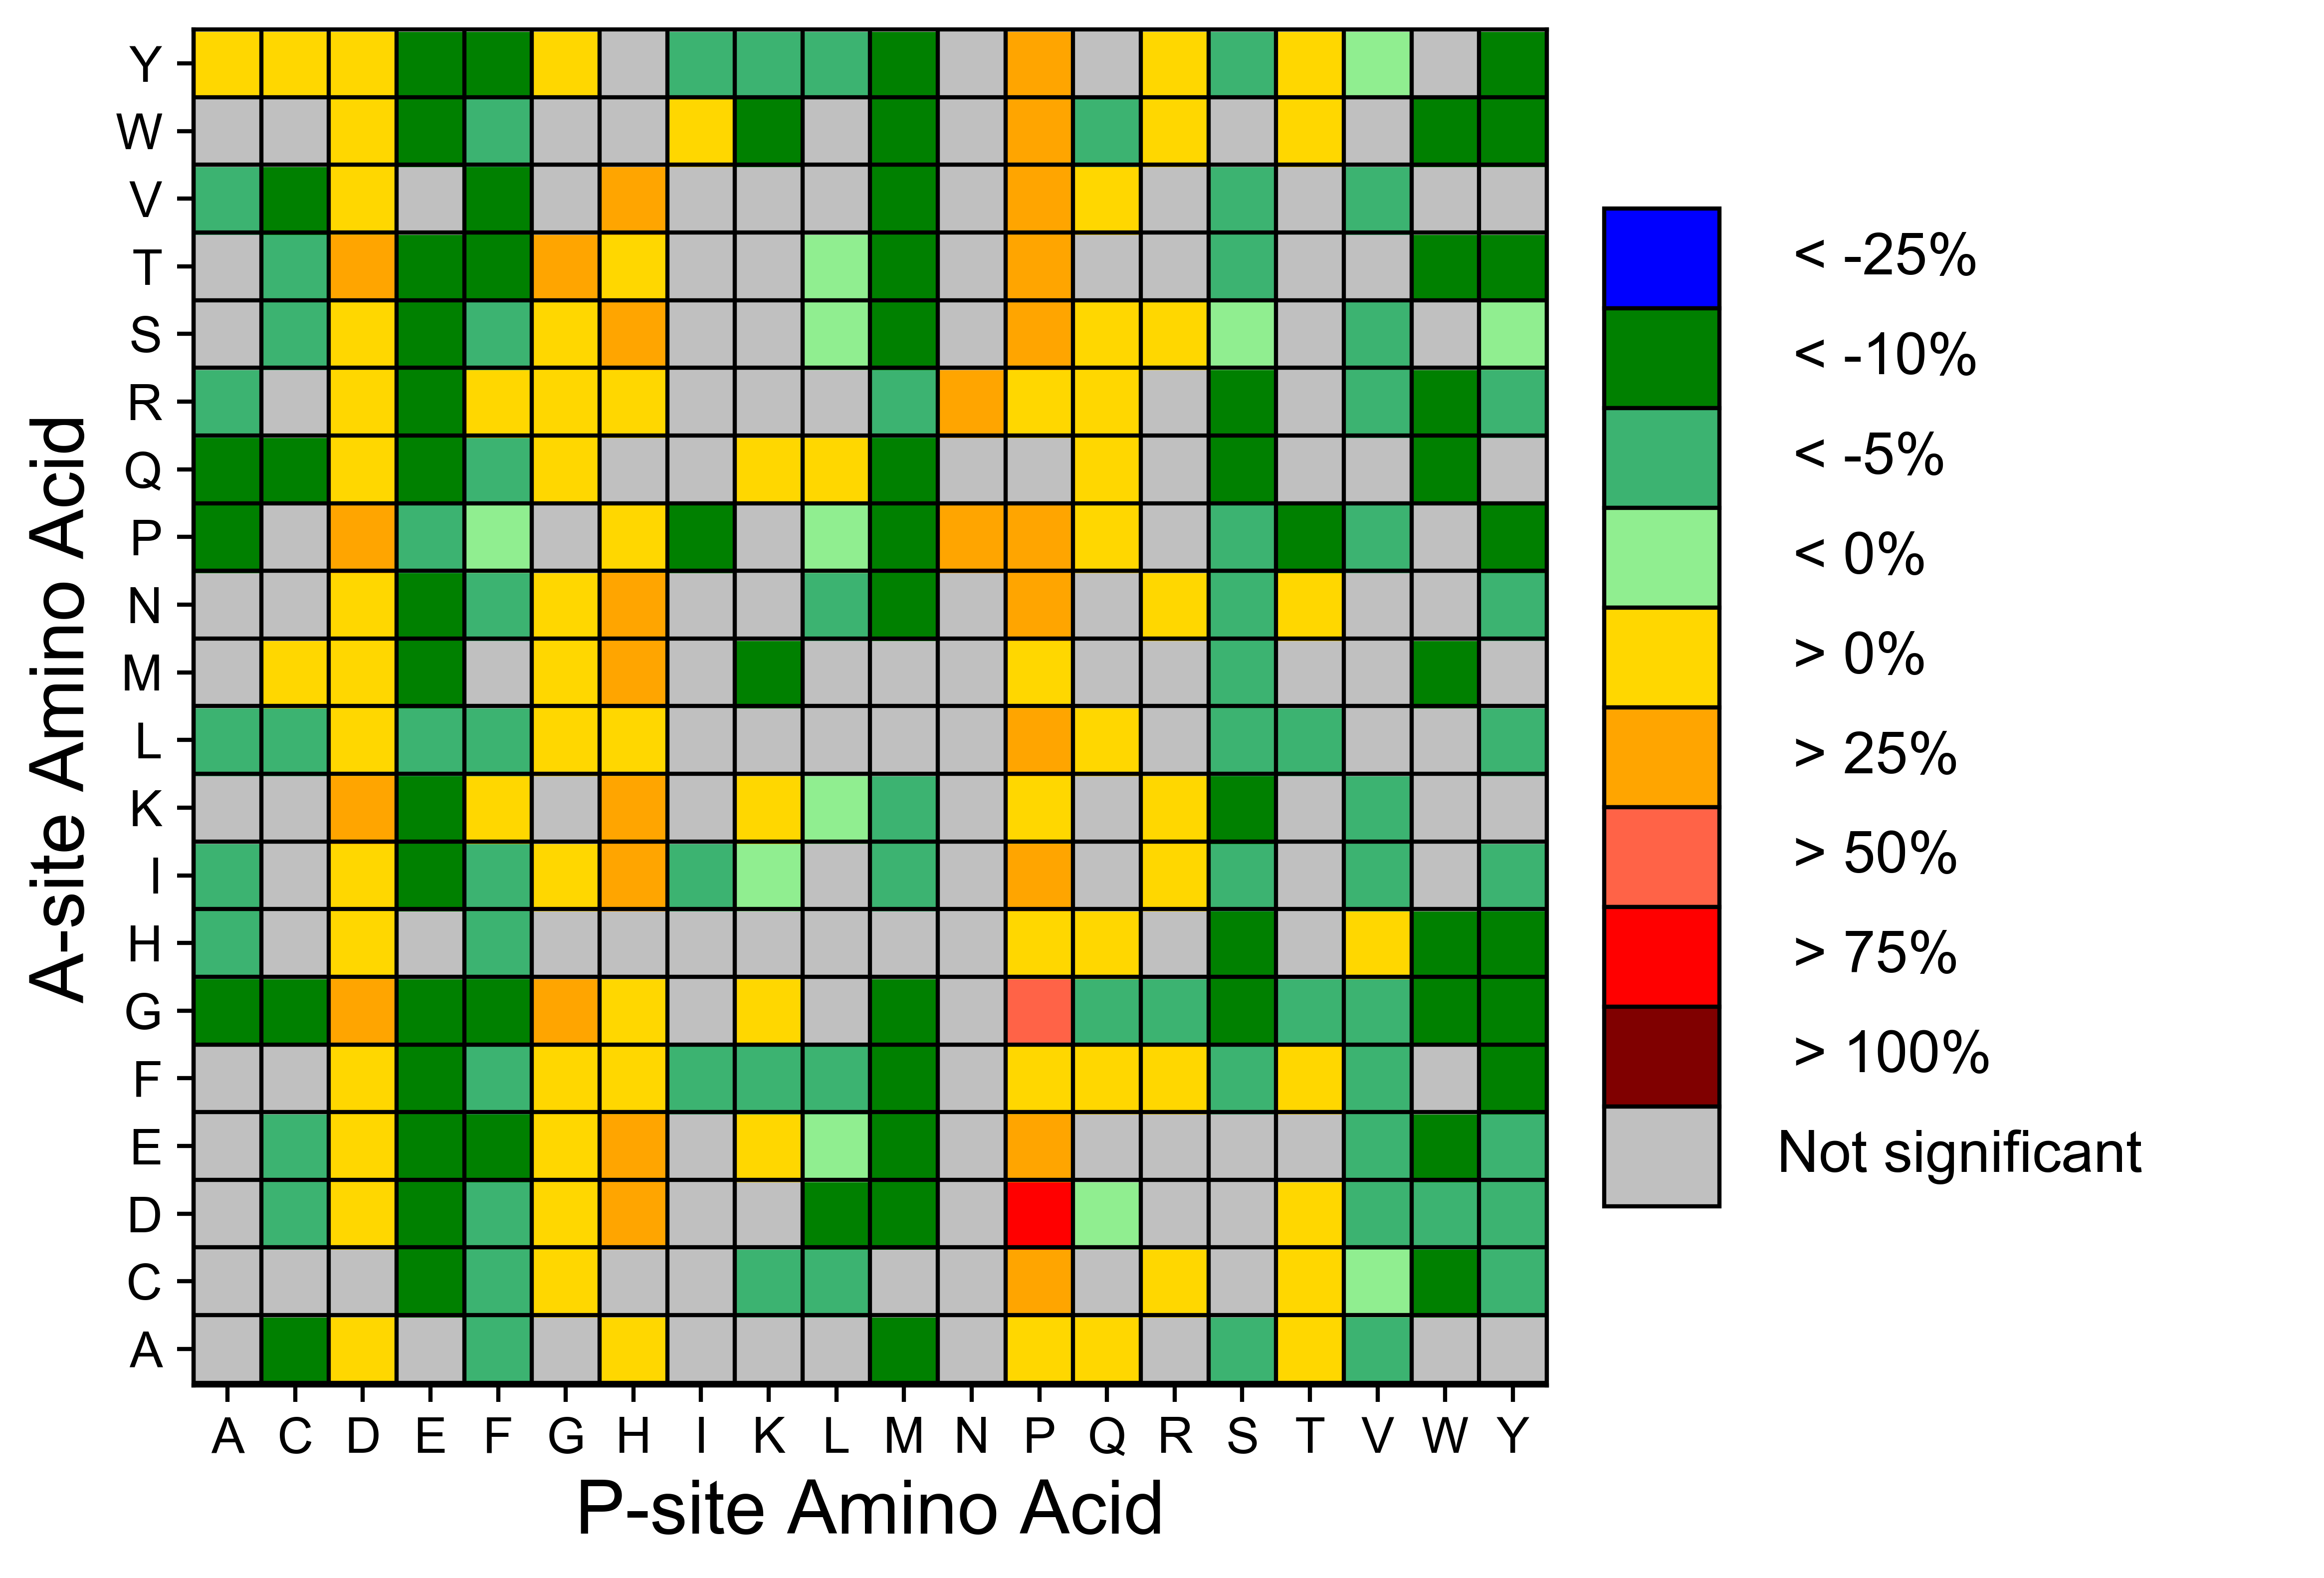

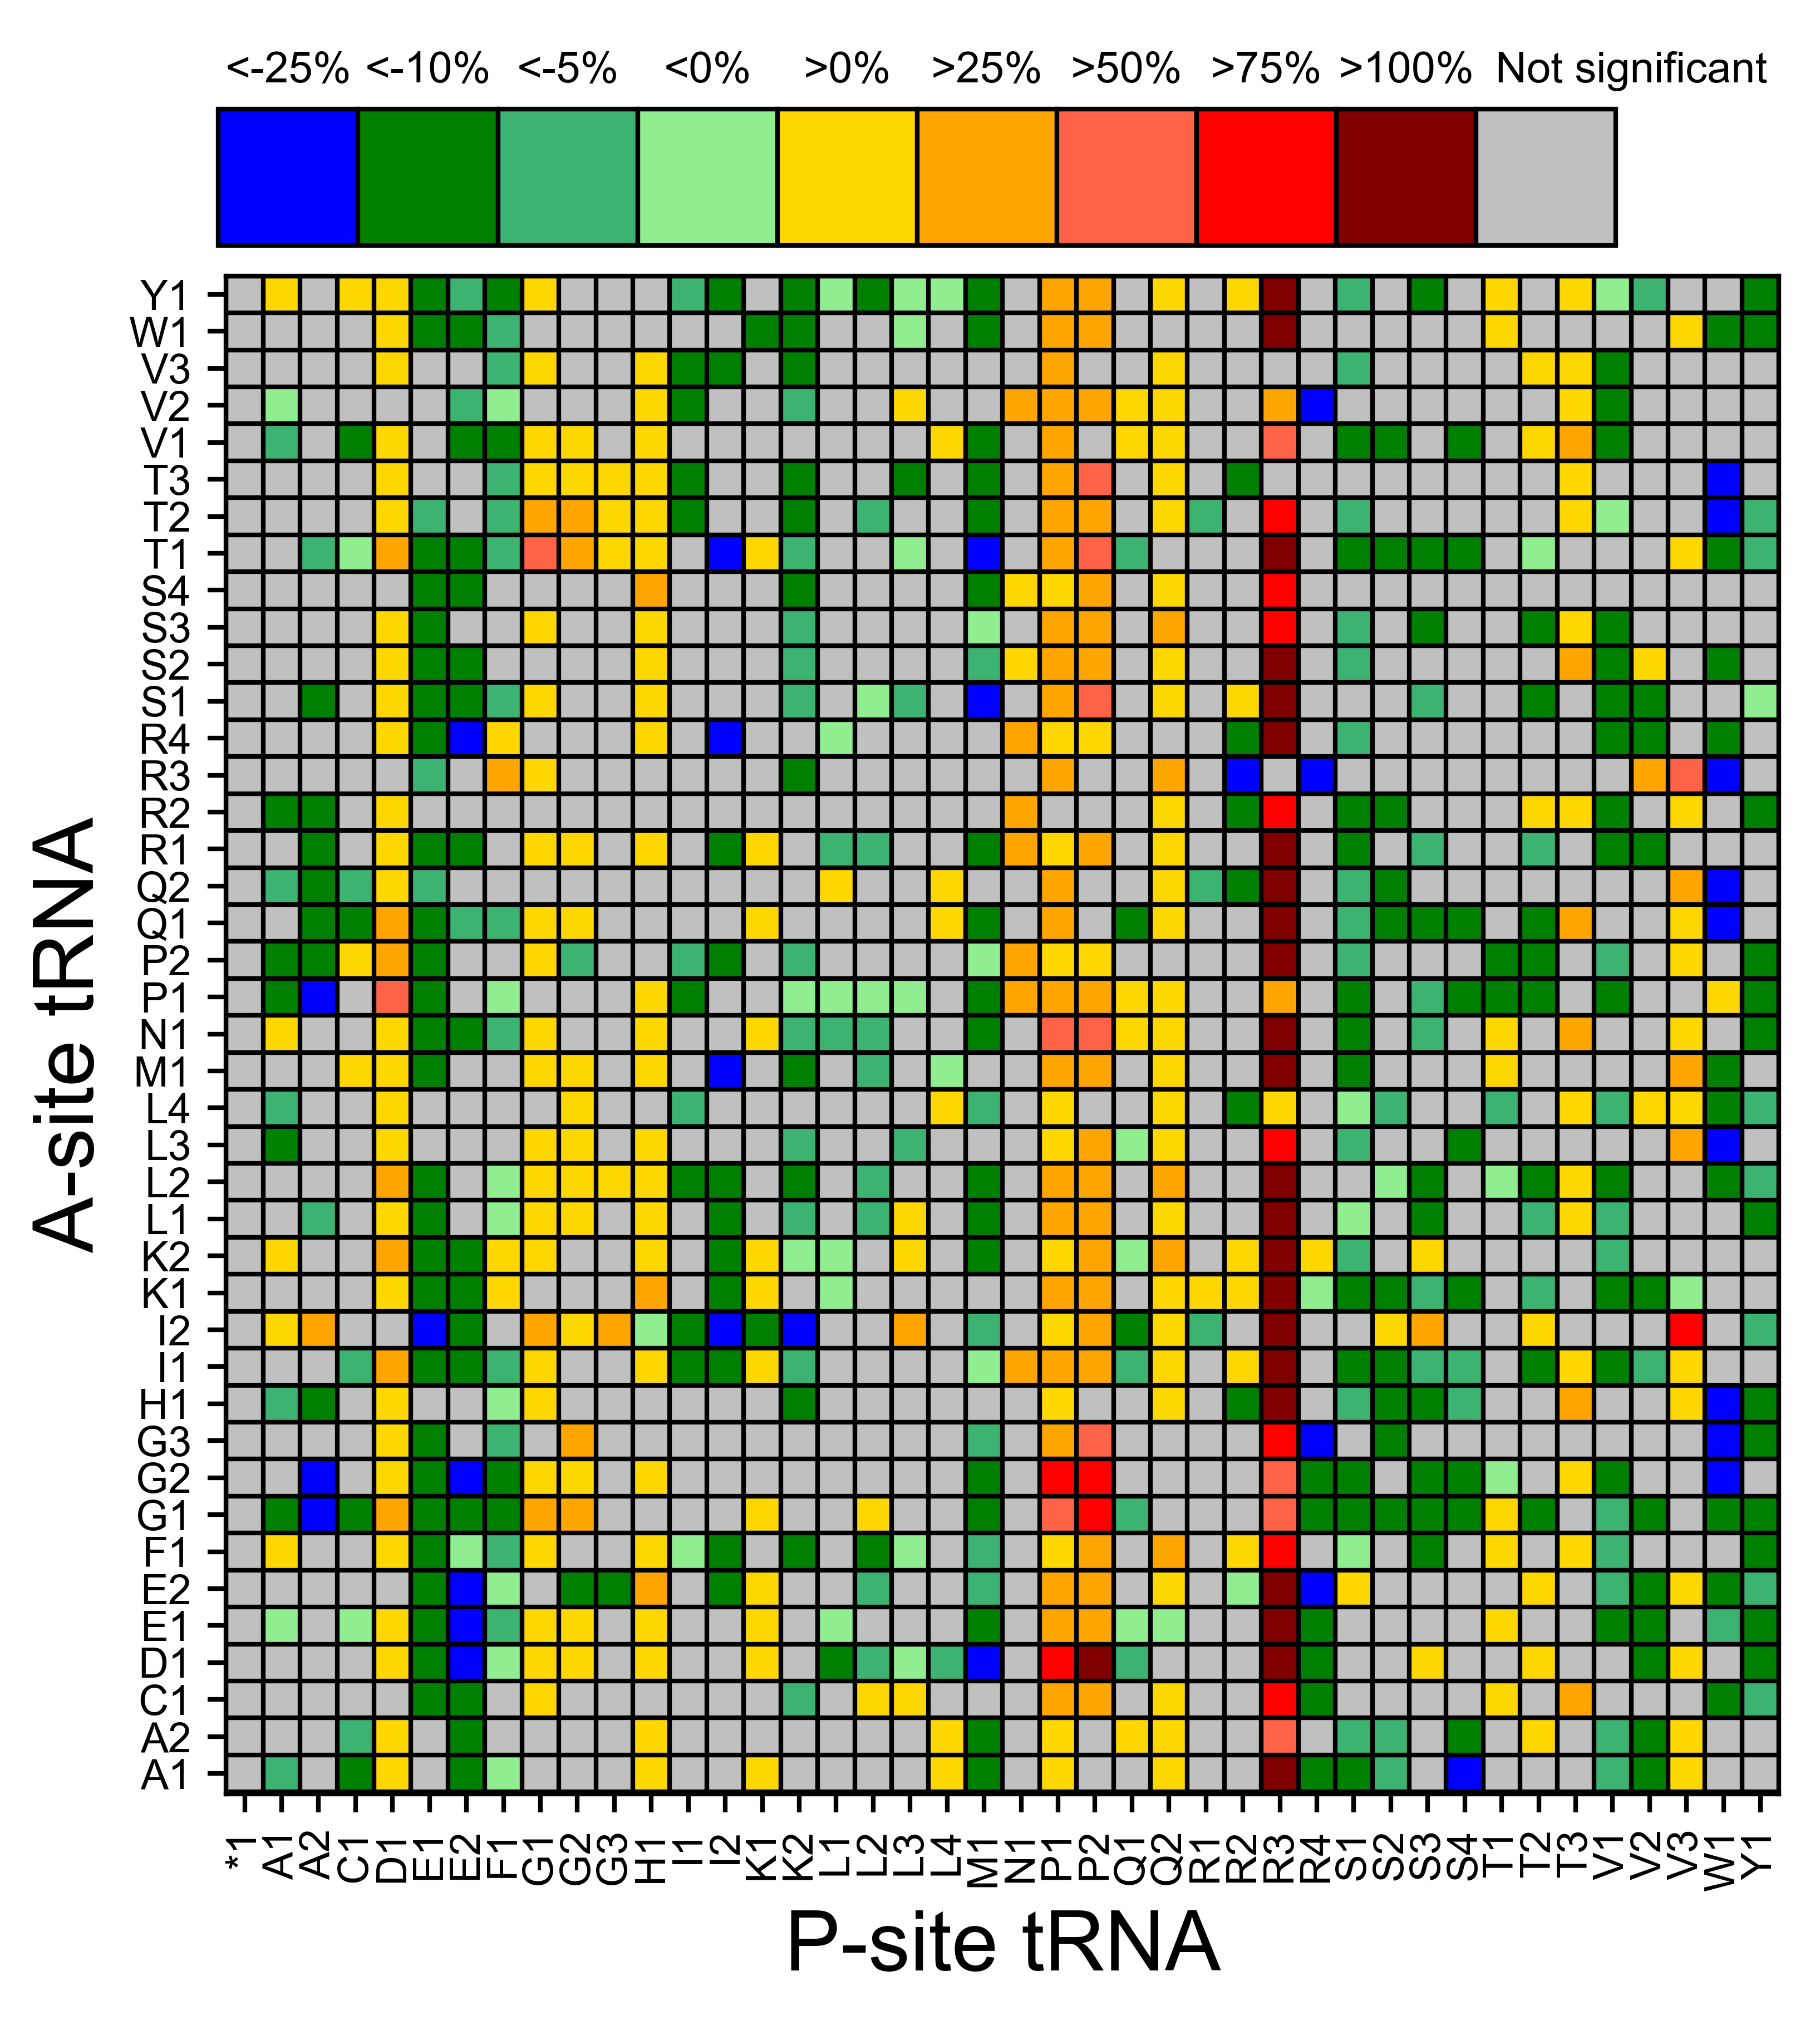

Done


In [28]:
pair_data = {}

# Get all plots of individual datasets to be plotted together as subpanels in Fig S1
plot_dict = {}

aa_file_path = 'psite_asite_matrix_for_amino_acid/'
tRNA_files_path = 'psite_asite_matrix_tRNA/'
combined_list = File_move(aa_file_path, tRNA_files_path)
print(combined_list)

tRNA_matrix = []
amino_aicd_matrix = []
for file in combined_list:
    if 'tRNA_level' in file:
        if data_sets[0] in file:
            tRNA_matrix.insert(0,file)
        elif data_sets[1] in file:
            tRNA_matrix.insert(1,file)
        elif data_sets[2] in file:
            tRNA_matrix.insert(2,file)
        elif data_sets[3] in file:
            tRNA_matrix.insert(3,file)
        elif data_sets[4] in file:
            tRNA_matrix.insert(4,file)
        elif data_sets[5] in file:
            tRNA_matrix.insert(5, file)
        elif data_sets[6] in file:
            tRNA_matrix.insert(6, file)
    elif 'matrix_perc_change' in file:
        if data_sets[0] in file:
            amino_aicd_matrix.insert(0,file)
        elif data_sets[1] in file:
            amino_aicd_matrix.insert(1,file)
        elif data_sets[2] in file:
            amino_aicd_matrix.insert(2,file)
        elif data_sets[3] in file:
            amino_aicd_matrix.insert(3,file)
        elif data_sets[4] in file:
            amino_aicd_matrix.insert(4,file)
        elif data_sets[5] in file:
            amino_aicd_matrix.insert(5, file)
        elif data_sets[6] in file:
            amino_aicd_matrix.insert(6, file)
    else:
        pass

print(tRNA_matrix)
count = 0
for datset in data_sets:
    pair_data[datset], perc_dict, pval_dict = parse_psite_matrix_info(tRNA_matrix[count])
    count+=1
measure_robustness_of_pairs(pair_data, data_sets, threshold=threshold_value, control_factor='Not_controlled_for_any_factors_tRNA_matrix')


#matrix for amino acid
print('Matrix for amino acid')
pair_data_1 = {}
count = 0
for datset in data_sets:
    pair_data_1[datset], perc_dict_1, pval_dict_1 = parse_psite_matrix_info_amino_acid(amino_aicd_matrix[count])
    count += 1

measure_robustness_of_pairs_amino_acid(pair_data_1, data_sets, threshold=threshold_value, control_factor='Not_controlled_for_any_factors_amino_acid_matrix')


#file moves in folder
shutil.copyfile('robust_tRNA_matrix/Robust_aminoacid_pairs_Not_controlled_for_any_factors_tRNA_matrix_'+str(threshold_value)+'_datasets.tab',
                'robust_tRNA_matrix/robust_all_not_filtered.tab')

#filter tab files
robust_file_name = tab_file_filter(
    'robust_tRNA_matrix/Robust_aminoacid_pairs_Not_controlled_for_any_factors_tRNA_matrix_'+str(threshold_value)+'_datasets.tab')
#create matrix fig for amino acid and tRNA
matrix_fig()
print('Done')

## Maxtrix create at codon lable

In [31]:
# Parses A-site file for reads per nucleotide.
# Converts reads per nucleotide to raw reads per codon. Then normalized read density profiles are obtained by dividing the raw reads at each codon position by average raw reads across the gene.
# Filters genes according to the criteria specified in options: list of genes/genes which have at least 3 reads per codon or/and do not overlap with any other genes or/and do not have introns
def gene_codon_filter(asite_file, mul_map_file, mul_map_threshold=0.1, filter_threshold=0.1, read_threshold=3, dataset='', all_genes=False, genelist=None, strict=True, relaxed=False, print_stats=False):
    # Total unique reads mapped to a gene
    unique_mapped_reads = {}
    # Total multiple mapped reads mapped to a gene
    mul_mapped_reads = {}

    # If the reads mapped to multiple positions constitute > mul_map_threshold of the total reads, then that gene's ribosome profile will not be considered for analysis
    # Genes with multiple mapped reads to be filtered out from analysis. Default threshold of 1%. Genes with more than 1% multiple mapped reads will be removed.
    mul_map_genes = []

    overlap_genes = pickle.load(open(Overlap_gene_list, 'rb'))
    intronic_genes = pickle.load(open(Intronic_gene_list, 'rb'))
    
    total_read_count = 0
    dict_len = {}
    codon_dict = {}
    # Parse the A-site file to get the reads for each position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(asite_file) as file_asite_table:
        for lines in file_asite_table:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            gene_length = int(line_list[1])
            # The list of reads mapped to A-sites along the nt positions of the transcript
            count_list = list(map(int, line_list[2].split(',')))
            # Quality check
            if len(count_list) % 3 != 0:
                print('QUALITY CHECK NOT MET: Gene '+gene+' have a length not a multiple of 3. The length is '+str(len(count_list)))
            if gene.startswith('Q'):
                continue
            codon_dict[gene] = []
            # Convert the reads per nucleotide to reads per codon
            for i in range(0, len(count_list), 3):
                codon_dict[gene].append(sum(count_list[i:i+3]))
            dict_len[gene] = gene_length
            unique_mapped_reads[gene] = sum(count_list)
            total_read_count += sum(count_list)
    print('Parsed the A-site file for '+dataset+ " dataset")

    # Get the number of mul mapped reads to decide whether to delete the gene or not. If a gene has more than 0.1% of reads multiple mapped, we delete it
    with open(mul_map_file) as f:
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            read_count = list(map(int, line_list[1:]))
            if sum(read_count) > 0:
                mul_mapped_reads[gene] = sum(read_count)

    if print_stats:
        print("\nGene mapping statistics for "+dataset+" dataset\n")
        print('Number of genes with A-site profiles: ' + str(len(dict_len)))
        print('Number of genes containing introns: ' + str(len(intronic_genes)))
        print('Number of genes containing overlaps: ' + str(len(overlap_genes)))
        print('Number of genes containing multiple aligned reads: ' + str(len(mul_mapped_reads)))
        print('Number of reads mapped to the yeast transcriptome: ' + str(total_read_count))

    # Count variables to determine the statistics of gene counts in each category
    no_of_genes = 0

    # Store the norm ribo density profiles for selected genes in this dict and return this dict
    norm_density_dict = {}

    for gene, gene_len in dict_len.items():
        if gene in mul_mapped_reads:
            try:
                perc_mul_map = float(mul_mapped_reads[gene]) * 100 / float(mul_mapped_reads[gene] + unique_mapped_reads[gene])
            except ZeroDivisionError:
                print('ZeroDivisionError for mul map calculation for gene '+str(gene))
                print(mul_mapped_reads[gene], unique_mapped_reads[gene])
                continue
            if perc_mul_map > mul_map_threshold:
                mul_map_genes.append(gene)

        # Writing out a file at codon level
        cod_len = len(codon_dict[gene])
        # Sanitary check
        if cod_len != gene_len / 3:
            print('Discrepancy in populating codon dicts. Length of codon dict (' + str(cod_len) + ') not equal to one-third of gene length (' + str(gene_len) + ')')

        mean_read_density = np.mean(codon_dict[gene])

        # Select for high coverage genes based on how many positions have non-zero reads
        number_of_zeroes = codon_dict[gene].count(0)
        
        # If this boolean is set to True, get the norm read density profiles for all genes
        if all_genes:
            norm_density_dict[gene] = [raw_density / mean_read_density for raw_density in codon_dict[gene]]
        # If a list of genes is specified, then the norm ribosome density profiles are obtained for these set of genes only
        elif genelist is not None and gene in genelist:
            if mean_read_density > 0.0:
                norm_density_dict[gene] = [raw_density / mean_read_density for raw_density in codon_dict[gene]]

        # In relaxed criteria, we will be selecting genes that have a certain percentage of codon positions with non-zero reads,
        # For example, for a filter threshold of 0.05, we will be selecting genes that have zero reads for less than 5% of positions
        # We are also not considering genes that may have overlapping CDS or genes that contain introns (These constitute < 6% of yeast transcriptome)
        elif relaxed and number_of_zeroes <= math.ceil(filter_threshold * cod_len):
            if gene not in overlap_genes and gene not in mul_map_genes and gene not in intronic_genes:
                no_of_genes += 1
                norm_density_dict[gene] = [raw_density/mean_read_density for raw_density in codon_dict[gene]]

        # If we apply the strict criteria where every codon position needs to have greater than read_threshold (default=1) reads
        elif strict:
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            # now each codon position should contain at least the read_threhsold number of reads for the gene to be included
            if all(v >= read_threshold for v in codon_dict[gene][2:]) and gene not in overlap_genes and gene not in intronic_genes and gene not in mul_map_genes:
                no_of_genes += 1
                norm_density_dict[gene] = [raw_density / mean_read_density for raw_density in codon_dict[gene]]
    if all_genes:
        print("Getting the norm ribo density profiles for all " + str(len(dict_len)) + " genes in " + dataset + " dataset")
    elif genelist is not None:
        print("Getting the norm ribo density profiles for a constant set of "+str(len(genelist))+" genes in "+dataset+" dataset")
    elif relaxed:
        print("No. of genes that have non-zero reads at greater than " + str(100-filter_threshold * 100) + "% of positions for "+dataset+" dataset: " + str(no_of_genes))
    elif strict:
        print("No. of genes with atleast " + str(read_threshold) + " reads in each codon position for "+dataset+" dataset is: " + str(no_of_genes))

    return norm_density_dict


print('Done')

Done


In [32]:
norm_ribo_codon_density_dict = {}

# For the expanded 64X61 matrix, we are using a relaxed criteria of at least 95% of codon positions having non-zero reads. This criteria is applied to the highest coverage Williams dataset. 
norm_ribo_codon_density_dict['Williams'] = gene_codon_filter('input/A-site_profiles_from_raw_Williams_data.tab', 'input/Multiple_mapped_gene_read_counts_20_35_Williams_data.tab', strict=False, relaxed=True, filter_threshold=0.25, dataset='Williams', print_stats=True)

# We obtain 1746 genes and we will use this list of genes to obtain normalized ribosome density profiles for other datasets
filtered_codon_geneset = list(norm_ribo_codon_density_dict['Williams'].keys())

datasets = ['Williams', 'Jan', 'Nissley1', 'Nissley2', 'Weinberg', 'Young']
for dataset in datasets:
    # we already got the norm ribo density profiles for Williams dataset
    if dataset == 'Williams':
        continue
    if dataset == 'Nissley1':
        norm_ribo_codon_density_dict[dataset] = gene_codon_filter('input/A-site_profiles_from_raw_Nissley1.tab', 'input/Multiple_mapped_gene_read_counts_20_35_Nissley1.tab', strict=False, relaxed=True, filter_threshold=0.25, dataset=dataset, print_stats=True)
        continue
    norm_ribo_codon_density_dict[dataset] = gene_codon_filter('input/A-site_profiles_from_raw_'+dataset+'_data.tab', 'input/Multiple_mapped_gene_read_counts_20_35_'+dataset+'_data.tab', strict=False, relaxed=True, filter_threshold=0.25, dataset=dataset, print_stats=True)
    

print('Done')

Parsed the A-site file for Williams dataset

Gene mapping statistics for Williams dataset

Number of genes with A-site profiles: 6376
Number of genes containing introns: 281
Number of genes containing overlaps: 297
Number of genes containing multiple aligned reads: 773
Number of reads mapped to the yeast transcriptome: 40297056
No. of genes that have non-zero reads at greater than 75.0% of positions for Williams dataset: 3145
Parsed the A-site file for Jan dataset

Gene mapping statistics for Jan dataset

Number of genes with A-site profiles: 6376
Number of genes containing introns: 281
Number of genes containing overlaps: 297
Number of genes containing multiple aligned reads: 719
Number of reads mapped to the yeast transcriptome: 21790227
No. of genes that have non-zero reads at greater than 75.0% of positions for Jan dataset: 2394
Parsed the A-site file for Nissley1 dataset

Gene mapping statistics for Nissley1 dataset

Number of genes with A-site profiles: 6376
Number of genes conta

## Add pool data at codon lable

In [33]:
# Convert the reads per codon of the filtered genes to translation times of codons
def reads_to_translation_times(codon_file, filename,coverage_value, genelist=''):
    translation_times = {}
    path1 = "Data_files/Published_data/pool_data/gene_codon_filter_pool/translation_time/"
    try:
        os.makedirs(path1)
    except OSError:
        print("Creation of the directory %s failed")
    else:
        print("Successfully created the directory %s ")

    #  If the translation times is to be calculated using instances from a constant set of genes, that list will be parsed here.
    # Make sure the times_dict passed here contain info for all genes and not just for filtered genes.
    list_of_genes = []
    list_of_genes = genelist
    
    # Parse the codon file to get the reads for each codon position of each gene
    # We get the reads info in dict_gene_count and the nucleotide info in nuc_dict
    with open(codon_file) as f:
        next(f)
        for lines in f:
            line_list = lines.strip().split('\t')
            gene = line_list[0]
            cov = coverage(line_list[2])
            if cov < coverage_value:
                continue
            gene = line_list[0]
            if genelist and gene not in list_of_genes:                
                continue
            count_list = list(map(int, line_list[2].split(',')))
            no_of_codons = len(count_list)
            synthesis_time = no_of_codons * 200
            # We remove the first two codons from the analysis since start codon is expected not to contain any reads and the second codon's ribosome density is influenced by initiation
            summed_reads = sum(count_list)
            if summed_reads == 0:
                continue
            ttime = [((float(reads) / float(summed_reads)) * synthesis_time)/200 for reads in count_list]
            translation_times[gene] = ttime

    return translation_times

def coverage(reads):
    reads = reads.split(",")
    c = 0 #Variable to store coverage across gene
    for read in reads:
        if float(read)>0:
            c+=1 #Add to collection
    c = (float(c/len(reads)))*100
    return c

In [34]:
combined_codon_profile = 'pool_data\gene_codon_filter_pool/A-site_profiles_Pool_Combined_codon-profiles.tab'
norm_ribo_codon_density_dict['Pool'] = reads_to_translation_times(combined_codon_profile, 'Pool',coverage_value, genelist='')

print ('\nDone')

Successfully created the directory %s 

Done


### Getting the codon level 64X61 matrix for Williams dataset

In [106]:
def psite_asite_matrix_codon_level(norm_ribo_dict, codon_type_dict):
    dict_asite_psite_instances = {}

    for codon in CODON_TYPES:
        dict_asite_psite_instances[codon] = {}
        for psite_codon in CODON_TYPES:
            # Stop codons cannot be in P-site
            if psite_codon in ['UGA', 'UAG', 'UAA']:
                continue
            dict_asite_psite_instances[codon][psite_codon] = []

    # Get all the instances with asite codon as primary key and psite codon as secondary key
    for gene, ribo_profile in norm_ribo_dict.items():
        for codon, ribo_density in enumerate(ribo_profile):
            # Ignoring the first two codons as they are influenced heavily by translation initiation
            if codon in [0, 1]:
                continue
            # Get the P-site codon
            try:
                psite_codon = codon_type_dict[gene][codon - 1]
            except KeyError:
                print('KeyError in codon type dict for gene ' + gene + ' at codon ' + str(codon))
                psite_codon = ''
            psite_aa = genetic_code[psite_codon]
            # Get the A-site codon
            try:
                asite = codon_type_dict[gene][codon]
            except KeyError:
                print('KeyError in codon type dict for gene ' + gene + ' at codon ' + str(codon + 1))
                asite = ''
            asite_aa = genetic_code[asite]

            # dict_asite_psite_instances will have a dict of p-site and t-times for all a-site asite. This is a dictionary initialized before for all combo of asite
            # dict_asite_psite_instances[Asite_codon][P-site_codon] = [ribo_density, gene, codon number, P-site AA, A-site AA]
            dict_asite_psite_instances[asite][psite_codon].append((float(ribo_density), gene, codon, psite_aa, asite_aa))

    # Initializing a dict for metrics to store for each pair of a-site and p-site
    dict_asite_psite_perc_change = {}
    dict_asite_psite_pval = {}
    dict_asite_psite_sample_size = {}

    # Initializing the inner dict for each a-site asite as key
    for codon in CODON_TYPES:
        dict_asite_psite_perc_change[codon] = {}
        dict_asite_psite_pval[codon] = {}
        dict_asite_psite_sample_size[codon] = {}
    # For each codon in A-site
    for aa_codon, dict_psite in dict_asite_psite_instances.items():
        # for all combinations of codons in P-site and their list of pair instances
        for psite_codon, pairs_instances_list in dict_psite.items():
            pairs_rdensity_list = []
            # the pairs_rdensity_list will contain only float values of norm ribo densities. pairs_instances_list contain many other values like gene name, codon number, codon type etc
            for pair_instance in pairs_instances_list:
                pairs_rdensity_list.append(pair_instance[0])
            # Create the list of trans time for all other codons in the P-site excluding the one being compared
            control_pair_rdensity_list = []
            for non_psite_codon, non_pair_instances_list in dict_psite.items():
                if non_psite_codon != psite_codon:
                    for pair_instance in non_pair_instances_list:
                        if not math.isnan(pair_instance[0]):  
                            control_pair_rdensity_list.append(pair_instance[0])
                else:
                    continue
            # Running comparisons only if there are at least 5 instances of the pair.
            if len(pairs_rdensity_list) >= 5:
                u, p = stats.mannwhitneyu(pairs_rdensity_list, control_pair_rdensity_list)
                # Using percent change as you want to know how much X in P-site causes slowdown/speedup in X-Z pair relative to when X is not present
                perc_change = ((np.median(pairs_rdensity_list) - np.nanmedian(control_pair_rdensity_list)) / np.nanmedian(control_pair_rdensity_list)) * 100
                dict_asite_psite_perc_change[aa_codon][psite_codon] = perc_change
                dict_asite_psite_pval[aa_codon][psite_codon] = p
                dict_asite_psite_sample_size[aa_codon][psite_codon] = [len(pairs_rdensity_list), len(control_pair_rdensity_list)]
            else:
                dict_asite_psite_perc_change[aa_codon][psite_codon] = 0  # 'Sample_less_than_5'
                dict_asite_psite_pval[aa_codon][psite_codon] = 1  # 'Sample_less_than_5'
                dict_asite_psite_sample_size[aa_codon][psite_codon] = [len(pairs_rdensity_list), len(control_pair_rdensity_list)]

    # Benjamini-Hochberg correction. We get all the p-values and pool them together in a list and adjust it
    list_of_pval = []
    for asite, data in sorted(dict_asite_psite_perc_change.items()):
        for p_site in sorted(data):
            list_of_pval.append(dict_asite_psite_pval[asite][p_site])
    hyp_test, pval_adj, alpsidac, alpbonf = mc.multipletests(list_of_pval, method='fdr_bh')

    dict_aa_psite_pval_adj = {}
    # Extract back the adjusted p-values into corresponding cells making sure that the keys are sorted according to when it was put in the list for multiple test correction
    i = 0
    for asite, data in sorted(dict_asite_psite_perc_change.items()):
        dict_aa_psite_pval_adj[asite] = {}
        for p_site, perc_change in sorted(data.items()):
            dict_aa_psite_pval_adj[asite][p_site] = pval_adj[i]
            i += 1
          
    return dict_asite_psite_perc_change, dict_aa_psite_pval_adj, dict_asite_psite_sample_size, dict_asite_psite_instances

def plot_asite_psite_codon_matrix(dict_asite_psite_metric, dict_asite_psite_adj_pval, dict_aa_psite_sample_size, title, txt=False, get_codon_stats=False, print_stats=False):
    # Converting the dict of dicts into list of lists to be converted to a numpy matrix
    # Three empty lists are added for the '*' codons which needs to appear in the first row before Y, W etc
    list_of_lists = [[], [], []]
    list_of_pval_adj = [[], [], []]
    row_labels = ['UAA', 'UAG', 'UGA']
    col_labels = []
    if get_codon_stats:
        outf = open("Inconsistent_two_box_codons.tab", "w")
        outfc = open("Consistent_two_box_codons.tab", "w")
    # Grouping the codons togehter based on the alphabetical order of their amino acids
    for aa in sorted(AMINO_ACIDS):
        for syn_list in synonymous[aa]:
            for codon in syn_list:
                if codon not in ['UAA', 'UAG', 'UGA']:
                    col_labels.append(codon)
    for aa in sorted(AMINO_ACIDS, reverse=True):
        for syn_list in synonymous[aa]:
            for asite_codon in syn_list:
                if asite_codon not in ['UAA', 'UAG', 'UGA']:
                    row_labels.append(asite_codon)
                psite_list = []
                psite_pval_adj_list = []
                for p_site_aa in sorted(AMINO_ACIDS):
                    for psite_syn_list in synonymous[p_site_aa]:
                        syn_perc_change = []
                        syn_pval = []
                        syn_sample_size = []
                        for psite_codon in psite_syn_list:
                            try:
                                # No stop codons in P-site
                                if psite_codon in ['UAA', 'UAG', 'UGA']:
                                    continue
                                psite_list.append(dict_asite_psite_metric[asite_codon][psite_codon])
                                psite_pval_adj_list.append(dict_asite_psite_adj_pval[asite_codon][psite_codon])
                                if get_codon_stats:
                                    syn_perc_change.append(dict_asite_psite_metric[asite_codon][psite_codon])
                                    syn_pval.append(dict_asite_psite_adj_pval[asite_codon][psite_codon])
                                    try:
                                        syn_sample_size.append(dict_aa_psite_sample_size[asite_codon][psite_codon][0])
                                    except KeyError:
                                        # print 'KeyError for syn_sample_size for asite codon ' + asite_codon + ' and psite codon ' + psite_codon
                                        syn_sample_size.append('NA')
                            except KeyError:
                                psite_list.append(0)
                                psite_pval_adj_list.append(1)
                                if get_codon_stats:
                                    syn_perc_change.append(0)
                                    syn_pval.append(1)
                                    try:
                                        syn_sample_size.append(dict_aa_psite_sample_size[asite_codon][psite_codon])
                                    except KeyError:
                                        syn_sample_size.append('NA')
                        if get_codon_stats:
                            if len(syn_perc_change) > 1:
                                if all(i < 0.05 for i in syn_pval):
                                    outfc.write(aa + '\t' + p_site_aa + '\t' + str(asite_codon) + '\t' + '\t'.join(psite_syn_list) + '\t' + '\t'.join(map(str, syn_perc_change)) + '\t' + '\t'.join(map(str, syn_pval)) + '\t' + '\t'.join(
                                        map(str, syn_sample_size)) + '\n')
                                else:
                                    outf.write(aa + '\t' + p_site_aa + '\t' + str(asite_codon) + '\t' + '\t'.join(psite_syn_list) + '\t' + '\t'.join(map(str, syn_perc_change)) + '\t' + '\t'.join(map(str, syn_pval)) + '\t' +
                                               '\t'.join(map(str, syn_sample_size)) + '\n')
                if asite_codon == 'UAA':
                    list_of_lists[0] = psite_list
                    list_of_pval_adj[0] = psite_pval_adj_list
                elif asite_codon == 'UAG':
                    list_of_lists[1] = psite_list
                    list_of_pval_adj[1] = psite_pval_adj_list
                elif asite_codon == 'UGA':
                    list_of_lists[2] = psite_list
                    list_of_pval_adj[2] = psite_pval_adj_list
                else:
                    list_of_lists.append(psite_list)
                    list_of_pval_adj.append(psite_pval_adj_list)

    ap_matrix = np.array(list_of_lists)
    ap_matrix_pval = np.array(list_of_pval_adj)

    ap_matrix_new = pd.DataFrame(ap_matrix, index=row_labels, columns=col_labels)
    
    # col label row is the row where the P-site labels will be placed, 22 for amino acids, 42 for trna and 65 for codons
    figure, pairs_stats = checkerboard_table(ap_matrix_new, ap_matrix_pval, txt=txt, xlabel='P-site Codon', ylabel='A-site Codon', col_label_row=65, figsize=(20, 10), fontsize=16)
    figure.suptitle(title, fontsize=9)

    if print_stats:
        print('\n\nSTATISTICS FOR AMINO ACIDS PAIRS at codon level\n')
        print('Total number of codon pairs: ' + str(pairs_stats['total_pairs']) + '\n')
        print('Total number of fast codon pairs: ' + str(pairs_stats['fast_sig_pair']) + '\n')
        print('Total number of slow codon pairs: ' + str(pairs_stats['slow_sig_pair']) + '\n')
        print('Total number of insignificant codon pairs: ' + str(pairs_stats['insig_pair']) + '\n')
        print('Total number of codon pairs with less than 5 instances: ' + str(pairs_stats['insufficient']) + '\n')
    return figure


def checkerboard_table(data, pval, fmt='{:.2f}', txt=False, xlabel='P-site Amino Acid', ylabel='A-site Amino Acid', col_label_row=22, figsize=None, fontsize=8):
    pairs_stats = {'total_pairs': 0, 'fast_sig_pair': 0, 'slow_sig_pair': 0, 'insig_pair': 0, 'insufficient': 0}
    if figsize:
        fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
    else:
        fig, ax = plt.subplots()
    plt.setp(ax.spines.values(), visible=False)
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False, direction='out', length=4, width=1)
    ax.grid(False)
    
    PA_label_tick = ['GCU {A}', 'GCC {A}', 'GCA {A}', 'GCG {A}', 'UGU {C}', 'UGC {C}', 'GAU {D}', 'GAC {D}',
                'GAA {E)', 'GAG {E}', 'UUU {F}', 'UUC {F}', 'GGU {G}', 'GGC {G}', 'GGA {G}', 'GGG {G}',
                'CAU {H}', 'CAC {H}', 'AUU {I}', 'AUC {I}', 'AUA {I}', 'AAA {K}', 'AAG {K}', 'CUU {L}', 
                'CUC {L}', 'UUA {L}', 'CUA {L}', 'UUG {L}', 'CUG {L}', 'AUG {M}', 'AAU {N}', 'AAC {N}', 
                'CCU {P}', 'CCC {P}', 'CCA {P}', 'CCG {P}', 'CAA {Q}', 'CAG {Q}', 'CGU {R}', 'CGC {R}',
                'CGA {R}', 'CGG {R}', 'AGA {R}', 'AGG {R}', 'UCU {S}', 'UCC {S}', 'UCA {S}', 'UCG {S}', 
                'AGU {S}', 'AGC {S}', 'ACU {T}', 'ACC {T}', 'ACA {T}', 'ACG {T}', 'GUU {V}', 'GUC {V}',   
                'GUA {V}', 'GUG {V}', 'UAU {Y}', 'UGG {W}', 'UAC {Y}', 'UAA {*}', 'UGA {*}', 'UAG {*}']

    AA_label_tick = ['UAC {Y}', 'UGG{W}', 'UAU {Y}', 'GUG {V}', 'GUA {V}', 'GUC {V}', 'GUU {V}', 'ACG {T}', 'ACA {T}', 'ACC {T}', 'ACU {T}', 'AGC {S}', 'AGU {S}', 
                     'UCG {S}', 'UCA {S}', 'UCC {S}', 'UCU {S}', 'AGG {R}', 'AGA {R}', 'CGG {R}', 'CGA {R}', 'CGC {R}', 'CGU {R}', 'CAG {Q}', 'CAA {Q}', 'CCG {P}', 
                     'CCA {P}', 'CCC {P}', 'CCU {P}', 'AAC {N}', 'AAU {N}', 'AUG {M}', 'CUG {L}', 'UUG {L}', 'CUA {L}', 'UUA {L}', 'CUC {L}', 'CUU {L}', 'AAG {K}', 
                     'AAA {K}', 'AUA {I}', 'AUC {I}', 'AUU {I}', 'CAC {H}', 'CAU {H}', 'GGG {G}', 'GGA {G}', 'GGC {G}', 'GGU {G}', 'UUC {F}', 'UUU {F}', 'GAG {E}', 
                     'GAA {E)', 'GAC {D}', 'GAU {D}', 'UGC {C}', 'UGU {C}', 'GCG {A}', 'GCA {A}', 'GCC {A}', 'GCU {A}']
    
    
    
    tb = Table(ax, bbox=[0, 0, 1, 1])
    mpl.rcParams['grid.linewidth'] = 0.5
    nrows, ncols = data.shape
    width, height = 1.0 / ncols, 1.0 / nrows
    # Add cells
    for (i, j), val in np.ndenumerate(data):
        pairs_stats['total_pairs'] += 1
        # Index either the first or second item of bkg_colors based on
        # a checker board pattern
        if pval[i][j] < 0.05:
            if val < 0:
                pairs_stats['fast_sig_pair'] += 1
            else:
                pairs_stats['slow_sig_pair'] += 1
            if val < -50:
                color = 'blue'
            elif val < -25:
                color = 'green'
            elif val < -10:
                color = 'mediumseagreen'     # darkcyan
            elif val < 0:
                color = 'lightgreen'   # cyan
            elif val > 100:
                # color = 'red'
                color = 'maroon'
            elif val > 75:
                # color = 'darkorange'  red
                color = 'red'
            elif val > 50:
                color = 'tomato'  # darkorange
            elif val > 25:
                color = 'orange'
            elif val > 0:
                color = 'gold'   # yellow
            else:
                color = 'grey'
        elif pval[i][j] == 1:
            color = 'grey'
            pairs_stats['insufficient'] += 1
        else:
            color = 'silver'  # lightgrey
            pairs_stats['insig_pair'] += 1
        if txt:
            tb.add_cell(i, j, width, width, text=fmt.format(val), loc='center', facecolor=color)
        else:
            tb.add_cell(i, j, width, width, loc='center', facecolor=color)
    for key, cell in tb.get_celld().items():
        cell.set_linewidth(0.5)
    # Row Labels...
    #for i, label in enumerate(data.index):
        #tb.add_cell(i, -1, width, width, text=label, loc='right', edgecolor='none', facecolor='none')
    # Column Labels...
    #for j, label in enumerate(data.columns):
        #tb.add_cell(col_label_row, j, width, width, text=label, loc='center', edgecolor='none', facecolor='none')
     
    # Row Labels...
    for i, label in enumerate(PA_label_tick):
        tb.add_cell(i, -1, width, width, text=label, loc='right', edgecolor='none', facecolor='none')
    # Column Labels...
    for j, label in enumerate(AA_label_tick):
        tb.add_cell(col_label_row, j, width, width, text=label, loc='center', edgecolor='none', facecolor='none')
        
    tb.set_fontsize(500) 
    ax.add_table(tb)
    ax.set_xlabel(xlabel, fontsize=6)
    ax.set_ylabel(ylabel, fontsize=6)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

    return fig, pairs_stats


print('Done')

Done




STATISTICS FOR AMINO ACIDS PAIRS at codon level

Total number of codon pairs: 3904

Total number of fast codon pairs: 1158

Total number of slow codon pairs: 1035

Total number of insignificant codon pairs: 1680

Total number of codon pairs with less than 5 instances: 31



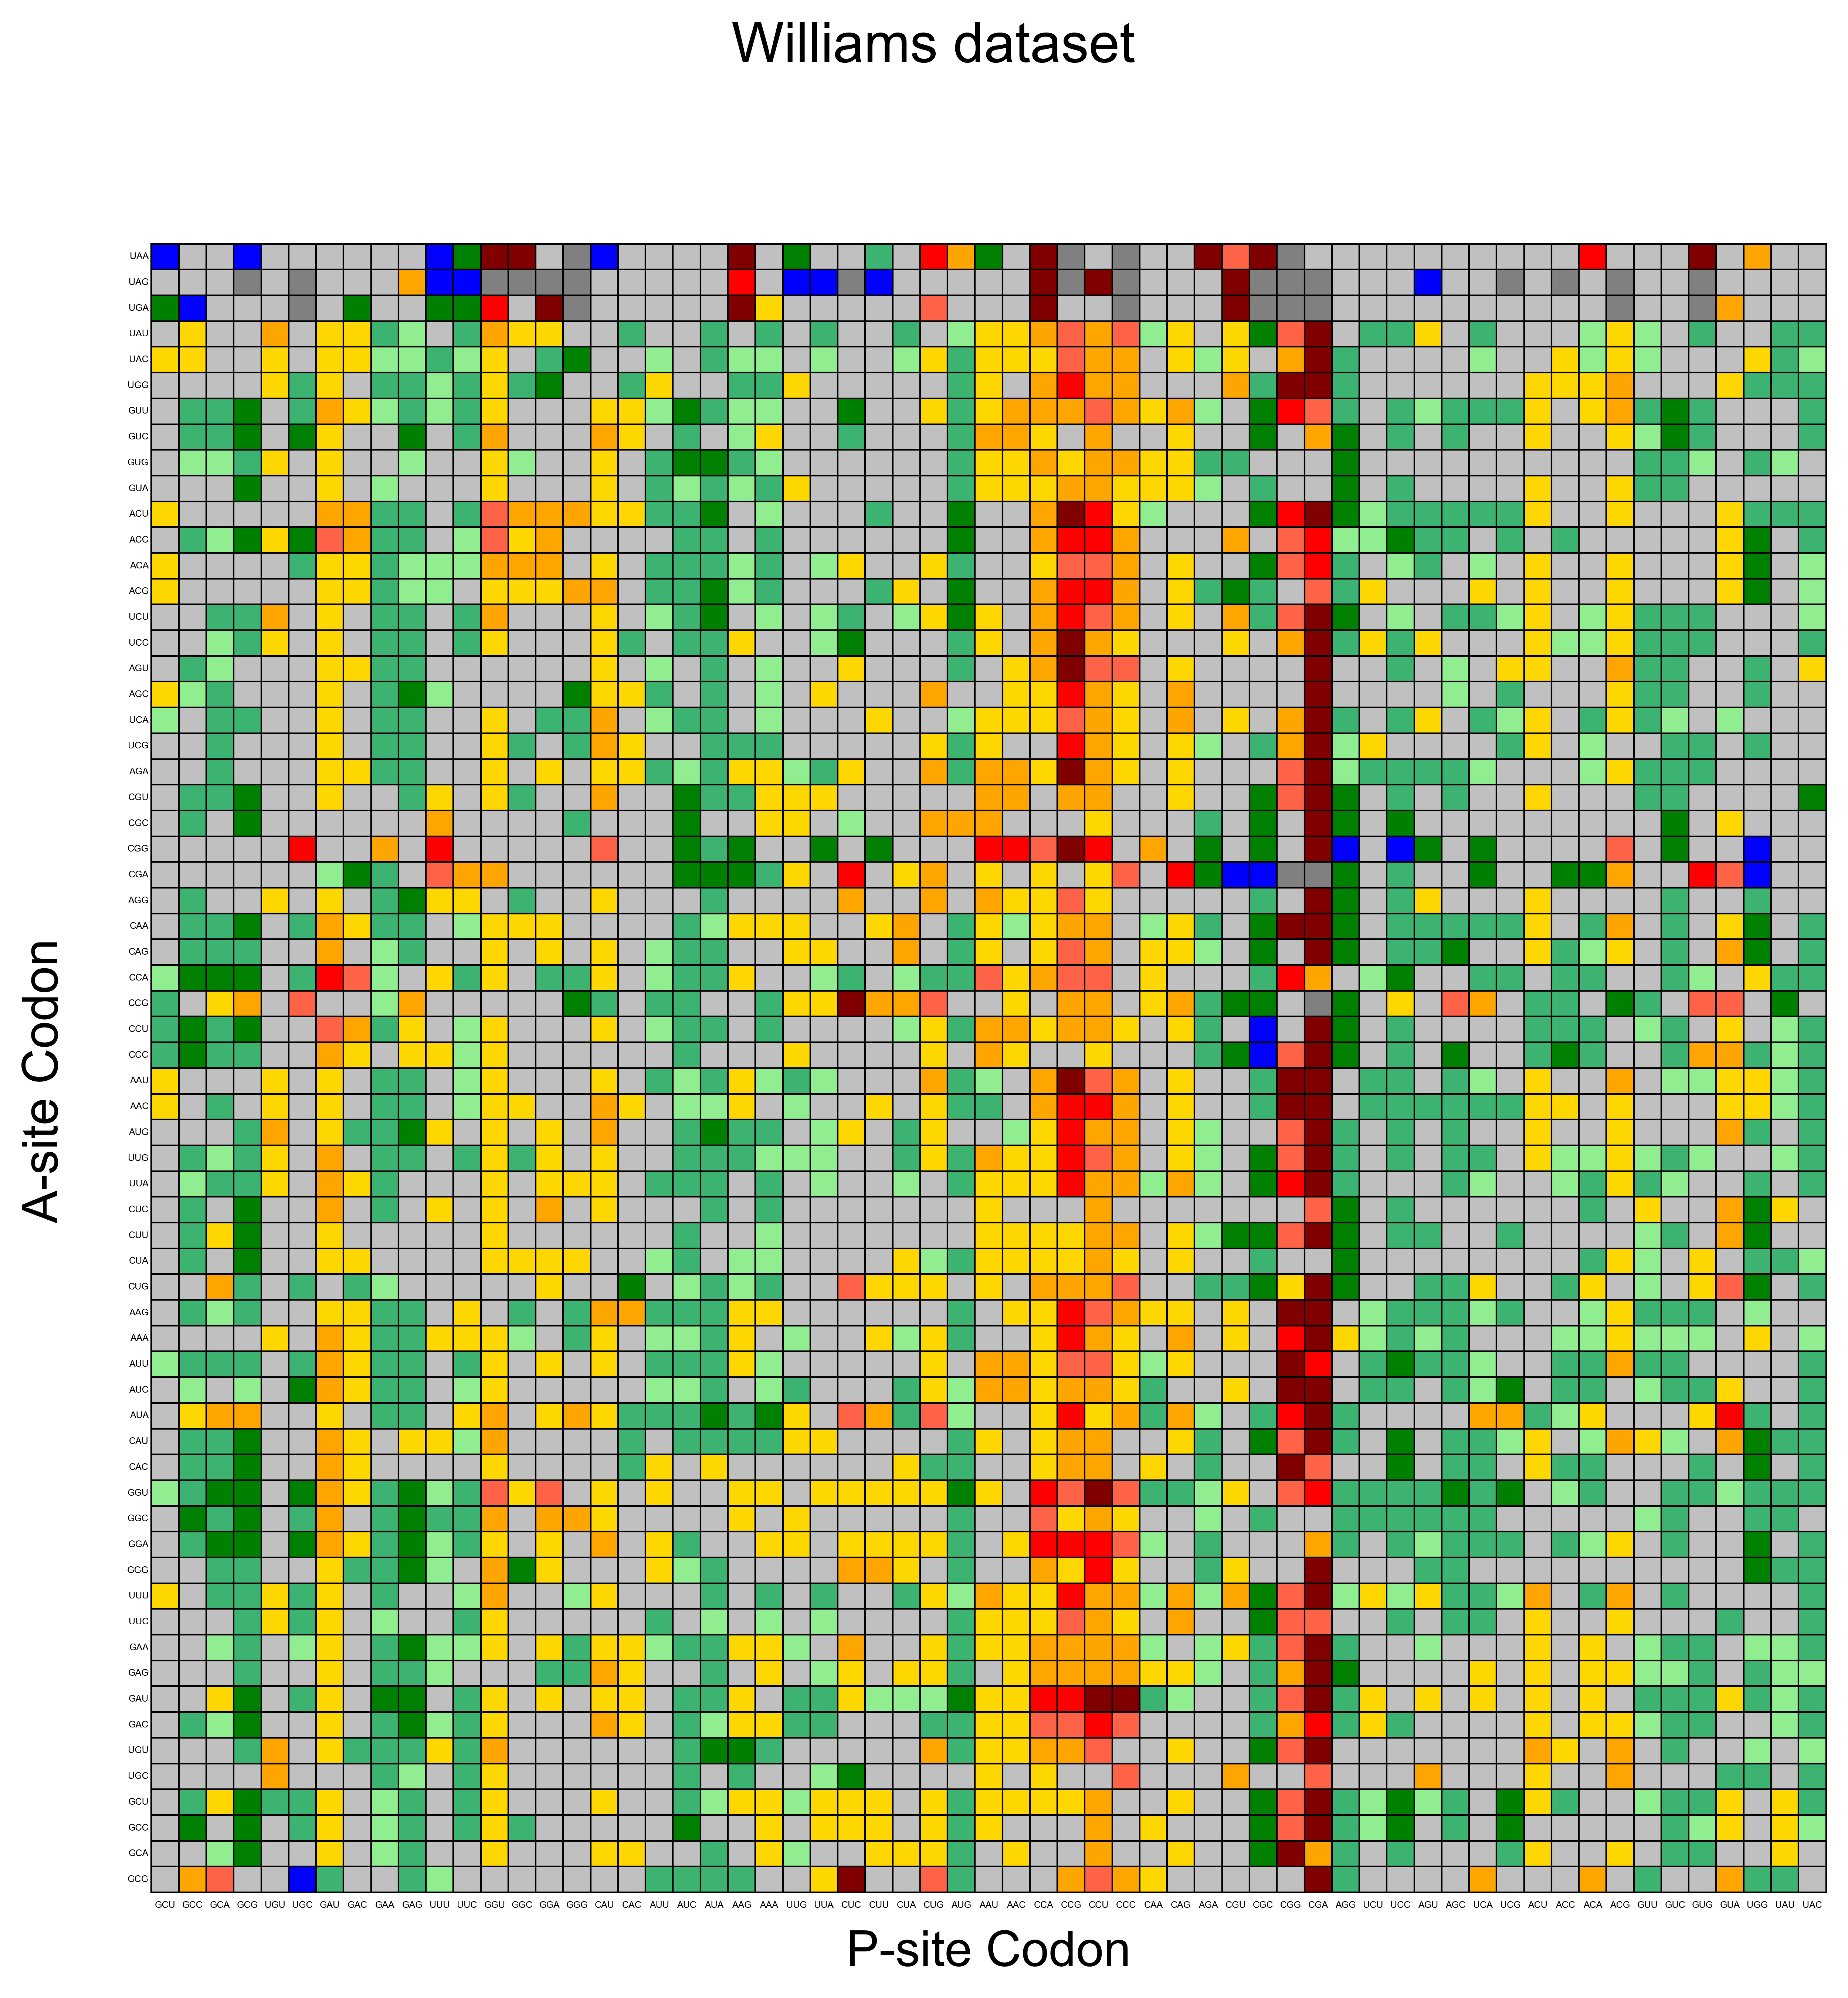

In [36]:
# Get the percent change values for all 3904(64X61) pair combinations in the 6 datasets
dict_codon_percent_change = {}
# Get the FDR corrected pvalues for all 3904 pair combinations in the 6 datasets
dict_codon_pval = {}
# Get the sample sizes for all 3904 combinations in the 6 datasets
dict_codon_sample_sizes = {}
# Get the list of norm ribo densitiy for all instances of the pair and its control for all 3904 combinations in the 6 datasets
dict_codon_instances = {}


# Running the analysis for Williams dataset
dict_codon_percent_change['Williams'], dict_codon_pval['Williams'], dict_codon_sample_sizes['Williams'], dict_codon_instances['Williams'] = psite_asite_matrix_codon_level(norm_ribo_codon_density_dict['Williams'], dict_cdn_types)
fig = plot_asite_psite_codon_matrix(dict_codon_percent_change['Williams'], dict_codon_pval['Williams'], dict_codon_sample_sizes['Williams'], 'Williams dataset', print_stats=True)
plt.show()

# The axes tick labels were formatted separately. Please review Fig. S10 for legible axes tick labels as well as the amino acid groupings

## Plotting the robust codon 64X61 matrix that is robust across 7 datasets

In [104]:
def measure_robustness_of_pairs_codon_level(datasets, dict_percent_change, dict_pval, threshold=4, print_stats=True, codon_level=False, title='Robust Matrix at codon level', plot_matrix=True):
    pair_stats = {}
    # Populating a dict with all the statistics
    for dataset in datasets:
        for asite_aa in dict_percent_change[dataset]:
            for psite_aa in dict_percent_change[dataset][asite_aa]:
                if codon_level:
                    pair = (psite_aa, asite_aa)
                else:
                    pair = psite_aa+asite_aa
                if pair not in pair_stats:
                    pair_stats[pair] = {'perc': [], 'adj_pval': []}
                pair_stats[pair]['perc'].append(dict_percent_change[dataset][pair[1]][pair[0]])
                pair_stats[pair]['adj_pval'].append(dict_pval[dataset][pair[1]][pair[0]])
    
    robust_pairs = {'Fast': [], 'Slow': [], 'Mixed': [], 'Not Robust': []}
    dict_robust_perc = {}
    dict_robust_pval = {}
    robust_pairs_percs = {}
    
    pair_stat_counter = 0
    for pair in pair_stats:
        if pair[1] not in dict_robust_perc:
            dict_robust_perc[pair[1]] = {}
            dict_robust_pval[pair[1]] = {}
        percs = pair_stats[pair]['perc']
        pvals = pair_stats[pair]['adj_pval']
        robust_pairs_percs[pair] = np.mean(percs)
       
        counter = 0
        # Counting in how many datasets, the pvalue is significant
        for pval in pvals:
            if pval < 0.05:
                counter += 1
        # The threshold is the number of datasets in which there should be a significant change in speed.
        if counter >= threshold:
            
            # All the pairs should show translational speed change in the same direction to be considered robust
            if all(p > 0 for p in percs):
                robust_pairs['Slow'].append(pair)
                dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                # Assigning a constant pvalue of 0 for significant pairs.
                dict_robust_pval[pair[1]][pair[0]] = 0
                
            elif all(p < 0 for p in percs):
                robust_pairs['Fast'].append(pair)
                dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                # Assigning a constant pvalue of 0 for significant pairs.
                dict_robust_pval[pair[1]][pair[0]] = 0
            else:
                pair_stat_counter += 1
                # Determine the trend in data
                # if at least the 'threshold' number of datasets show same direction
                if sum(p > 0 for p in percs) >= threshold:
                    updated_percs = []
                    for idx, val in enumerate(pvals):
                        if val < 0.05:
                            updated_percs.append(percs[idx])
                elif sum(p < 0 for p in percs) >= threshold:
                    updated_percs = []
                    for idx, val in enumerate(pvals):
                        if val < 0.05:
                            updated_percs.append(percs[idx])
                else:
                    updated_percs = percs
                # in addition to condition in above comment, if all significant data sets show same direction
                if all(p > 0 for p in updated_percs):
                    robust_pairs['Slow'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0 for significant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0
                elif all(p < 0 for p in updated_percs):
                    robust_pairs['Fast'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0 for significant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0
                else:
                    robust_pairs['Mixed'].append(pair)
                    dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
                    # Assigning a constant p-value of 0.5 for insignificant pairs.
                    dict_robust_pval[pair[1]][pair[0]] = 0.5
        else:
            robust_pairs['Not Robust'].append(pair)
            dict_robust_perc[pair[1]][pair[0]] = np.mean(percs)
            # Assigning a constant p-value of 0.5 for insignificant pairs.
            dict_robust_pval[pair[1]][pair[0]] = 0.5

    outf = open('Robust_aminoacid_pairs_' + str(threshold) + '_datasets.tab', 'w')
    outf.write('Pair\tPair_type\tAvg(Perc change)')
    for data_set in datasets:
        outf.write('\t Perc change(' + str(data_set) + ')')
    outf.write('\t')
    for data_set in datasets:
        outf.write('\t p-value(' + str(data_set) + ')')
    outf.write('\n')
    for pair_type in robust_pairs:
        for pair in robust_pairs[pair_type]:
            pair_list = list(pair)
            asite_codon = pair_list[0]
            psite_codon = pair_list[1]
            ap_site_codon = str(asite_codon)+','+str(psite_codon)
            outf.write(str(ap_site_codon) + '\t')
            outf.write(pair_type + '\t')
            outf.write(str(np.mean(pair_stats[pair]['perc'])) + '\t')
            outf.write('\t'.join(map(str, pair_stats[pair]['perc'])) + '\t')
            outf.write('\t'.join(map(str, pair_stats[pair]['adj_pval']))  + '\n')        
 

    if print_stats:
        # print("Total possible P-site and A-site pairs: ")+str(len(pair_stats))
        print("Total pairs that are robust across the datasets: "+str((len(robust_pairs['Fast'])+len(robust_pairs['Slow']))))
        print("Total pairs that are robust and slow-translating pairs: "+str(len(robust_pairs['Slow'])))
        print("Total pairs that are robust and fast-translating pairs: " + str(len(robust_pairs['Fast'])))
    if plot_matrix:
        if codon_level:
            robust_matrix_plot = plot_asite_psite_codon_matrix(dict_robust_perc, dict_robust_pval, dict_robust_perc, title='Robust Codon Matrix')
        else:
            robust_matrix_plot = plot_asite_psite_matrix(dict_robust_perc, dict_robust_pval, title)
        return robust_matrix_plot, pair_stats, robust_pairs, robust_pairs_percs, dict_robust_perc, dict_robust_pval
    else:
        return pair_stats, robust_pairs, robust_pairs_percs, dict_robust_perc, dict_robust_pval

print('\nDone')


Done


Total pairs that are robust across the datasets: 1453
Total pairs that are robust and slow-translating pairs: 698
Total pairs that are robust and fast-translating pairs: 755


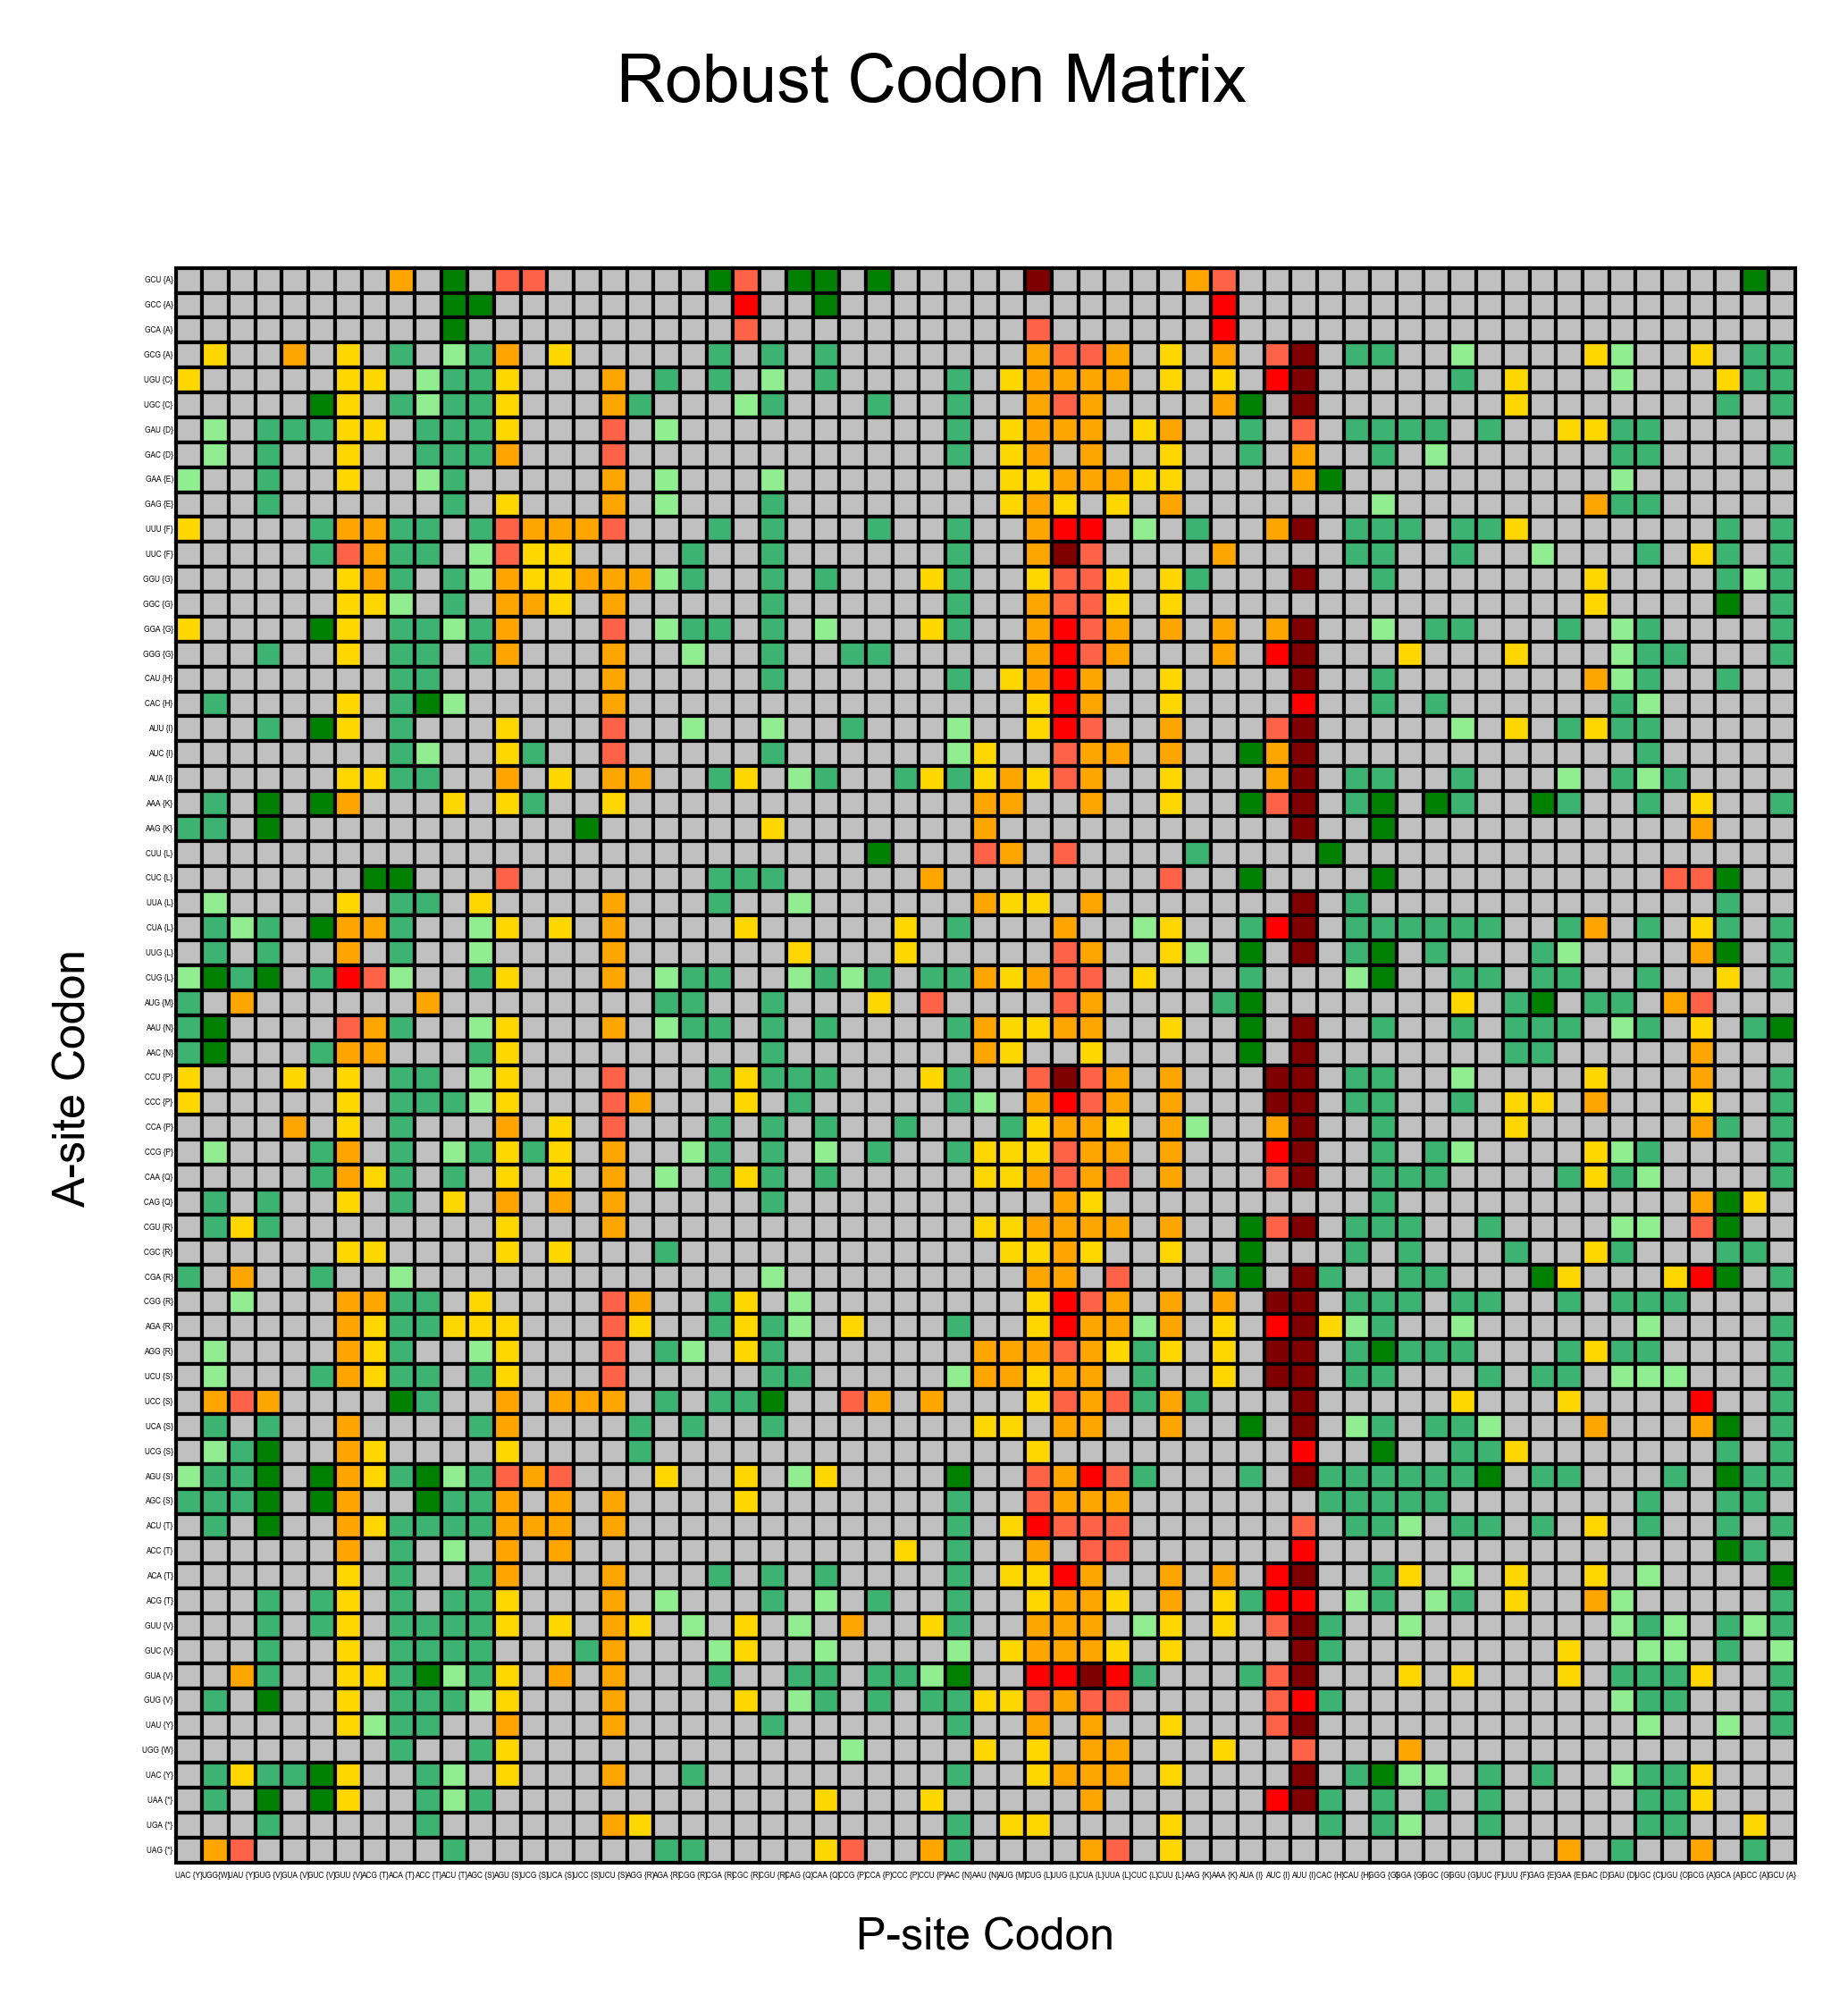

In [105]:
for dataset in data_sets:
    dict_codon_percent_change[dataset], dict_codon_pval[dataset], dict_codon_sample_sizes[dataset], dict_codon_instances[dataset] = psite_asite_matrix_codon_level(norm_ribo_codon_density_dict[dataset], dict_cdn_types)

matrix_codon_plot, codon_pair_stats, robust_pairs_codon_dict, robust_pairs_codon_percs_dict, robust_pairs_codon_mean_perc_dict, robust_pairs_codon_pval_dict = measure_robustness_of_pairs_codon_level(data_sets, dict_codon_percent_change, dict_codon_pval, threshold=4, codon_level=True)
fig.savefig('codon_lavel_matrix.png', dpi=300)
plt.show()